<a href="https://www.kaggle.com/code/dataranch/idealista-listings-eda-feature-importance?scriptVersionId=106770314" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Spain Real Estate Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

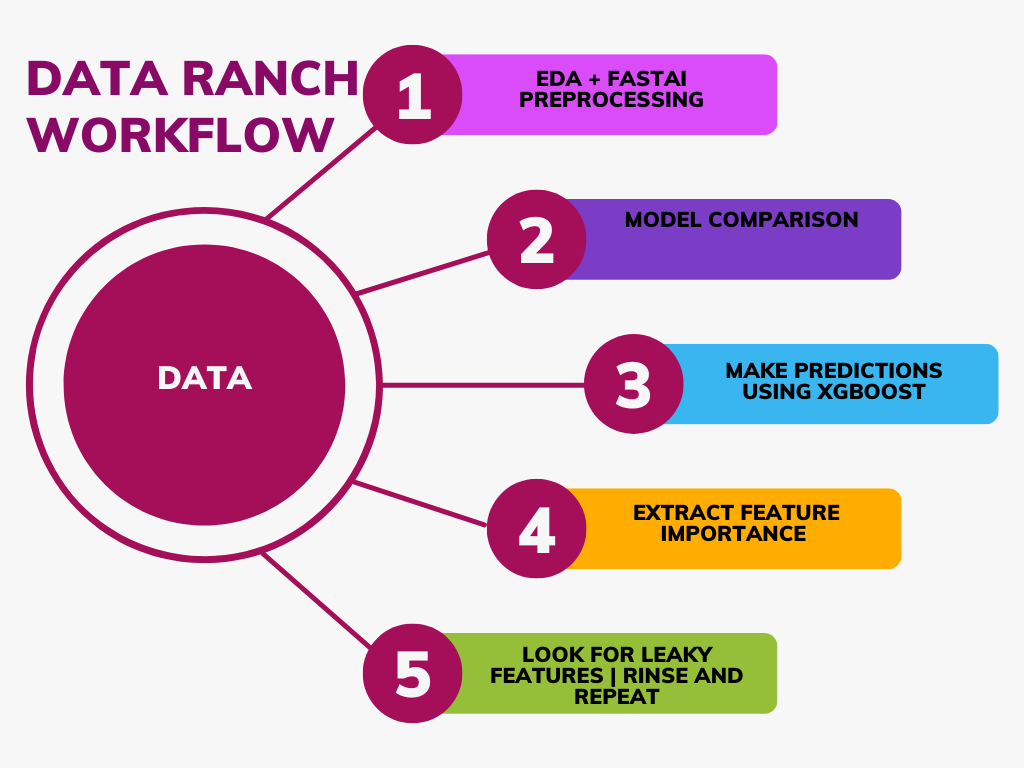

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 506.8 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'idealista-madrid-rental-real-state'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [9]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/idealista-madrid-rental-real-state
CSV!


In [10]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
df

propertyCode  \
0        98903350   
1        91615378   
2        88363329   
3        98621753   
4        98222714   
..            ...   
445      98815692   
446      97765107   
447      98620594   
448      98791417   
449      88490656   

                                                                                        thumbnail  \
0    https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/7a/b5/61/1027174063.jpg   
1    https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/59/73/3f/1024519300.jpg   
2    https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/0e/a1/25/1025350613.jpg   
3    https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/96/1a/25/1018319776.jpg   
4    https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/6c/2d/5b/1022163220.jpg   
..                                                                                            ...   
445  https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/9d/72/69/1024671265.jpg   
446   https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/03/f8/dc/989708380.jpg   
447  https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/36/d5/1f/1018288747.jpg   
448  https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/7a/b7/a9/1023937294.jpg   
449  https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/da/d9/4a/1009906600.jpg   

     numPhotos  price propertyType operation   size  exterior  rooms  \
0           33 550.00       chalet      rent 371.00     False      6   
1           12 750.00         flat      rent  60.00      True      1   
2           21 750.00         flat      rent  70.00      True      2   
3           28 400.00    penthouse      rent  67.00      True      2   
4           22 450.00         flat      rent  89.00     False      2   
..         ...    ...          ...       ...    ...       ...    ...   
445         16 640.00         flat      rent  69.00      True      2   
446         19 700.00         flat      rent  54.00      True      1   
447         16 700.00         flat      rent  59.00      True      1   
448         11 700.00         flat      rent  75.00      True      2   
449         19 695.00         flat      rent  62.00     False      2   

     bathrooms  ... superTopHighlight topNewDevelopment  \
0            3  ...             False             False   
1            1  ...             False             False   
2            1  ...             False             False   
3            2  ...             False             False   
4            1  ...             False             False   
..         ...  ...               ...               ...   
445          1  ...             False             False   
446          1  ...             False             False   
447          1  ...             False             False   
448          1  ...             False             False   
449          1  ...             False             False   

          externalReference floor                    district  \
0                       NaN   NaN                         NaN   
1                      AV23     3                   Hortaleza   
2                       NaN    bj               Centro Urbano   
3                     90004     2                         NaN   
4           RP1882022101719     2                         NaN   
..                      ...   ...                         ...   
445  2806/28060001/00000281     2                         NaN   
446           CH-95178-0001     1               Getafe Centro   
447                     NaN     6                 Carabanchel   
448                     NaN     1  Pryconsa - Poligono Europa   
449                     NaN     3           Alcobendas Centro   

           neighborhood  hasLift  \
0                   NaN      NaN   
1              Canillas     True   
2                   NaN    False   
3                   NaN    False   
4   

In [12]:
df.isna().sum()

propertyCode                0
thumbnail                   1
numPhotos                   0
price                       0
propertyType                0
operation                   0
size                        0
exterior                    0
rooms                       0
bathrooms                   0
address                     0
province                    0
municipality                0
country                     0
latitude                    0
longitude                   0
showAddress                 0
url                         0
distance                    0
description                 1
hasVideo                    0
status                      0
newDevelopment              0
priceByArea                 0
detailedType                0
suggestedTexts              0
hasPlan                     0
has3DTour                   0
has360                      0
hasStaging                  0
superTopHighlight           0
topNewDevelopment           0
externalReference          92
floor     

In [13]:
sns.heatmap(df.corr())

<AxesSubplot:>

In [14]:
df.head().style.background_gradient(cmap = "inferno")

In [15]:
df.describe().T.style.background_gradient(cmap = "viridis")

In [16]:
df.columns

Index(['propertyCode', 'thumbnail', 'numPhotos', 'price', 'propertyType',
       'operation', 'size', 'exterior', 'rooms', 'bathrooms', 'address',
       'province', 'municipality', 'country', 'latitude', 'longitude',
       'showAddress', 'url', 'distance', 'description', 'hasVideo', 'status',
       'newDevelopment', 'priceByArea', 'detailedType', 'suggestedTexts',
       'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight',
       'topNewDevelopment', 'externalReference', 'floor', 'district',
       'neighborhood', 'hasLift', 'parkingSpace', 'labels',
       'newDevelopmentFinished'],
      dtype='object')

In [17]:
#remove leaky features
del(df['propertyCode'])
del(df['address'])
del(df['latitude'])
del(df['longitude'])
del(df['description'])
del(df['url'])
del(df['suggestedTexts'])
del(df['externalReference'])

In [18]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

Target Variable: newDevelopmentFinished
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error with  district
Error with  neighborhood
Continuous variables that made the cut : ['numPhotos', 'price', 'size', 'distance', 'priceByArea']
Categorical variables that made the cut : ['propertyType', 'oper

 14%|█▍        | 6/42 [00:00<00:00, 56.42it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.2643678160919538, 'Adjusted R-Squared': -0.6923076923076918, 'RMSE': 0.11918282365569904, 'Time taken': 0.02147507667541504}
{'Model': 'BaggingRegressor', 'R-Squared': 0.6965517241379311, 'Adjusted R-Squared': 0.5938461538461539, 'RMSE': 0.05838742081211422, 'Time taken': 0.027637720108032227}
{'Model': 'BayesianRidge', 'R-Squared': 0.004072746711083042, 'Adjusted R-Squared': -0.3330103236328581, 'RMSE': 0.10577688236319037, 'Time taken': 0.025513648986816406}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010242223739624023}
{'Model': 'DummyRegressor', 'R-Squared': -0.0062961752230583645, 'Adjusted R-Squared': -0.34688872683701644, 'RMSE': 0.10632609528611549, 'Time taken': 0.00932931900024414}
{'Model': 'ElasticNet', 'R-Squared': -0.0062961752230583645, 'Adjusted R-Squared': -0.34688872683701644, 'RMSE': 0.10632609528611549, 'Time taken': 0.01174473762512207}
{'Model': 'Elasti

 29%|██▊       | 12/42 [00:00<00:01, 24.59it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992900501, 'Adjusted R-Squared': 0.9999999990497594, 'RMSE': 2.82416982903147e-06, 'Time taken': 0.08635210990905762}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6665810934251768, 'Adjusted R-Squared': 0.5537316173536981, 'RMSE': 0.06120290911124183, 'Time taken': 0.19440793991088867}


 38%|███▊      | 16/42 [00:00<00:01, 18.53it/s]

{'Model': 'HuberRegressor', 'R-Squared': -1.0409191608719457, 'Adjusted R-Squared': -1.7316917999362964, 'RMSE': 0.15142230597361186, 'Time taken': 0.051989078521728516}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.10988505747126442, 'Adjusted R-Squared': -0.19138461538461526, 'RMSE': 0.1, 'Time taken': 0.013019561767578125}
{'Model': 'KernelRidge', 'R-Squared': -89.67040691649052, 'Adjusted R-Squared': -120.3588523343796, 'RMSE': 1.0092755130163498, 'Time taken': 0.04862403869628906}
{'Model': 'Lars', 'R-Squared': -0.01971943992002001, 'Adjusted R-Squared': -0.3648552503544882, 'RMSE': 0.10703290270518763, 'Time taken': 0.060628652572631836}
{'Model': 'LarsCV', 'R-Squared': -0.00035552357775769927, 'Adjusted R-Squared': -0.33893739309638327, 'RMSE': 0.10601178360604463, 'Time taken': 0.07020092010498047}


 52%|█████▏    | 22/42 [00:01<00:00, 20.70it/s]

{'Model': 'Lasso', 'R-Squared': -0.0062961752230583645, 'Adjusted R-Squared': -0.34688872683701644, 'RMSE': 0.10632609528611549, 'Time taken': 0.012948989868164062}
{'Model': 'LassoCV', 'R-Squared': -0.010316462531237969, 'Adjusted R-Squared': -0.35226972677258006, 'RMSE': 0.10653827703303921, 'Time taken': 0.0691230297088623}
{'Model': 'LassoLars', 'R-Squared': -0.0062961752230583645, 'Adjusted R-Squared': -0.34688872683701644, 'RMSE': 0.10632609528611549, 'Time taken': 0.010985612869262695}
{'Model': 'LassoLarsCV', 'R-Squared': -0.00983423560961616, 'Adjusted R-Squared': -0.35162428458517847, 'RMSE': 0.10651284848704863, 'Time taken': 0.03143620491027832}
{'Model': 'LassoLarsIC', 'R-Squared': 0.00623311565558915, 'Adjusted R-Squared': -0.33011875289174974, 'RMSE': 0.10566209428476238, 'Time taken': 0.016116619110107422}
{'Model': 'LinearRegression', 'R-Squared': -0.019719439920018678, 'Adjusted R-Squared': -0.3648552503544864, 'RMSE': 0.10703290270518756, 'Time taken': 0.011030673980

 69%|██████▉   | 29/42 [00:01<00:00, 17.81it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.2585739476730793, 'Adjusted R-Squared': -0.6845528222701214, 'RMSE': 0.11890943703445915, 'Time taken': 0.31728196144104004}
{'Model': 'NuSVR', 'R-Squared': 0.9768363242343027, 'Adjusted R-Squared': 0.9689963108982205, 'RMSE': 0.016131720649310632, 'Time taken': 0.05365729331970215}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.043807665910843285, 'Adjusted R-Squared': -0.3970964143729747, 'RMSE': 0.1082897111268203, 'Time taken': 0.02278304100036621}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.043807665910843285, 'Adjusted R-Squared': -0.3970964143729747, 'RMSE': 0.1082897111268203, 'Time taken': 0.03435039520263672}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.3299058317861603, 'Adjusted R-Squared': -0.780027805621476, 'RMSE': 0.12223269841855029, 'Time taken': 0.013206958770751953}
{'Model': 'PoissonRegressor', 'R-Squared': 0.22605069524121613, 'Adjusted R-Squared': -0.0359013771386798, 'RMSE': 0.093246644242

 76%|███████▌  | 32/42 [00:02<00:01,  6.11it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.011494252873572863, 'Adjusted R-Squared': -0.3538461538461666, 'RMSE': 0.10660035817780573, 'Time taken': 1.290686845779419}
{'Model': 'RANSACRegressor', 'R-Squared': -0.011494252873562871, 'Adjusted R-Squared': -0.35384615384615326, 'RMSE': 0.10660035817780522, 'Time taken': 0.0638735294342041}


 81%|████████  | 34/42 [00:03<00:01,  6.45it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8501977011494253, 'Adjusted R-Squared': 0.7994953846153846, 'RMSE': 0.041023828995530705, 'Time taken': 0.17462420463562012}
{'Model': 'Ridge', 'R-Squared': -0.01609903944094926, 'Adjusted R-Squared': -0.3600094835594243, 'RMSE': 0.1068427295484148, 'Time taken': 0.012681961059570312}
{'Model': 'RidgeCV', 'R-Squared': 0.0066834441627051655, 'Adjusted R-Squared': -0.32951600550530213, 'RMSE': 0.10563815102115313, 'Time taken': 0.011283159255981445}
{'Model': 'SGDRegressor', 'R-Squared': -0.16034168198326326, 'Adjusted R-Squared': -0.5530727128083677, 'RMSE': 0.11417470569719597, 'Time taken': 0.0111236572265625}
{'Model': 'SVR', 'R-Squared': 0.1796294980273887, 'Adjusted R-Squared': -0.0980343641787258, 'RMSE': 0.09600237389967008, 'Time taken': 0.012457609176635742}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.019719439920018678, 'Adjusted R-Squared': -0.3648552503544864, 'RMSE': 0.10703290270518756, 'Time taken': 0.011470079

100%|██████████| 42/42 [00:03<00:00, 11.57it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9579603620018944, 'Adjusted R-Squared': 0.9437315614486894, 'RMSE': 0.021732336, 'Time taken': 0.3866407871246338}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7051117233582138, 'Adjusted R-Squared': 0.6053033835717632, 'RMSE': 0.05755800172416295, 'Time taken': 0.11498761177062988}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: newDevelopmentFinished
newDevelopmentFinished
Target Standard Deviation: 0.13922284215086558
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
DecisionTreeRegressor                        1.00       1.00  0.00        0.01
ExtraTreeRegressor                           1.00       1.00  0.00        0.01
ExtraTreesRegressor                          1.00       1.00  0.00        0.10
GradientBoostingRegressor                    1.00       1.00  0.00        0.09
NuSVR                   

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.12338069081306458.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  0.021732336
Target Variable: hasLift
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error wi

 17%|█▋        | 7/42 [00:00<00:00, 42.61it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.1041636901199714, 'Adjusted R-Squared': -0.19904244553173056, 'RMSE': 0.47275400802461054, 'Time taken': 0.02641916275024414}
{'Model': 'BaggingRegressor', 'R-Squared': 0.06628245888923068, 'Adjusted R-Squared': -0.249745016563645, 'RMSE': 0.48264592939270706, 'Time taken': 0.031494140625}
{'Model': 'BayesianRidge', 'R-Squared': 0.2238749072297067, 'Adjusted R-Squared': -0.03881358570793103, 'RMSE': 0.44003452379587, 'Time taken': 0.011076927185058594}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.0922435312596015, 'Adjusted R-Squared': -0.46192595722438967, 'RMSE': 0.5220121717327898, 'Time taken': 0.010305643081665039}
{'Model': 'DummyRegressor', 'R-Squared': -0.0011340936737189722, 'Adjusted R-Squared': -0.33997947922482386, 'RMSE': 0.4997663541102212, 'Time taken': 0.009360551834106445}
{'Model': 'ElasticNet', 'R-Squared': -0.0011340936737189722, 'Adjusted R-Squared': -0.33997947922482386, 'RMSE': 0.4997663541102212, 'Time taken': 

 29%|██▊       | 12/42 [00:00<00:01, 20.81it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.07440244560666054, 'Adjusted R-Squared': -0.4380463502735301, 'RMSE': 0.5177312540891776, 'Time taken': 0.1478254795074463}
{'Model': 'GammaRegressor', 'R-Squared': 0.1901019714778759, 'Adjusted R-Squared': -0.0840173612526891, 'RMSE': 0.44950658657242926, 'Time taken': 0.012177228927612305}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -6.632304956105198, 'Adjusted R-Squared': -9.215546633556187, 'RMSE': 1.3799035954541605, 'Time taken': 0.05445456504821777}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.14585025695317677, 'Adjusted R-Squared': -0.14324657915497863, 'RMSE': 0.46162348587632684, 'Time taken': 0.13293838500976562}


 36%|███▌      | 15/42 [00:00<00:01, 17.82it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.1446938602632084, 'Adjusted R-Squared': -0.1447943716477056, 'RMSE': 0.4619358662983029, 'Time taken': 0.18864941596984863}
{'Model': 'HuberRegressor', 'R-Squared': 0.19907484263934627, 'Adjusted R-Squared': -0.07200751831349028, 'RMSE': 0.447009606528909, 'Time taken': 0.019861698150634766}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.08720496894409924, 'Adjusted R-Squared': -0.2217410415671286, 'RMSE': 0.4772077877898398, 'Time taken': 0.011927127838134766}
{'Model': 'KernelRidge', 'R-Squared': -9.032141827489696, 'Adjusted R-Squared': -12.427635984486207, 'RMSE': 1.582040949353905, 'Time taken': 0.0412447452545166}
{'Model': 'Lars', 'R-Squared': 0.19884907186393774, 'Adjusted R-Squared': -0.07230970381288326, 'RMSE': 0.44707260529565673, 'Time taken': 0.054621219635009766}
{'Model': 'LarsCV', 'R-Squared': 0.18588467091445837, 'Adjusted R-Squared': -0.08966205585295572, 'RMSE': 0.45067540220775554, 'Time taken': 0.069730520

 52%|█████▏    | 22/42 [00:01<00:00, 21.60it/s]

{'Model': 'Lasso', 'R-Squared': -0.0011340936737189722, 'Adjusted R-Squared': -0.33997947922482386, 'RMSE': 0.4997663541102212, 'Time taken': 0.01160573959350586}
{'Model': 'LassoCV', 'R-Squared': 0.19285712053696447, 'Adjusted R-Squared': -0.08032970020437058, 'RMSE': 0.44874135893787204, 'Time taken': 0.06579136848449707}
{'Model': 'LassoLars', 'R-Squared': -0.0011340936737189722, 'Adjusted R-Squared': -0.33997947922482386, 'RMSE': 0.4997663541102212, 'Time taken': 0.010184526443481445}
{'Model': 'LassoLarsCV', 'R-Squared': 0.18588467091445837, 'Adjusted R-Squared': -0.08966205585295572, 'RMSE': 0.45067540220775554, 'Time taken': 0.02727651596069336}
{'Model': 'LassoLarsIC', 'R-Squared': 0.2155543471439686, 'Adjusted R-Squared': -0.04995033536114968, 'RMSE': 0.4423869622216855, 'Time taken': 0.014824390411376953}
{'Model': 'LinearRegression', 'R-Squared': 0.19884907186393674, 'Adjusted R-Squared': -0.0723097038128846, 'RMSE': 0.447072605295657, 'Time taken': 0.010455608367919922}
{'M

 69%|██████▉   | 29/42 [00:01<00:01, 12.39it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.12113616134754734, 'Adjusted R-Squared': -0.17632544558097507, 'RMSE': 0.46825420560713377, 'Time taken': 0.734832763671875}
{'Model': 'NuSVR', 'R-Squared': 0.15428183500771342, 'Adjusted R-Squared': -0.13196123622044498, 'RMSE': 0.45933942063895516, 'Time taken': 0.05192756652832031}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.1654588087182347, 'Adjusted R-Squared': -0.11700128679251653, 'RMSE': 0.4562940205125672, 'Time taken': 0.021263599395751953}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.1654588087182347, 'Adjusted R-Squared': -0.11700128679251653, 'RMSE': 0.4562940205125672, 'Time taken': 0.033377647399902344}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.3463471026239844, 'Adjusted R-Squared': -0.8020338142813328, 'RMSE': 0.579561341389819, 'Time taken': 0.012269735336303711}
{'Model': 'PoissonRegressor', 'R-Squared': 0.2074966141745478, 'Adjusted R-Squared': -0.0607353010279128, 'RMSE': 0.444653230657253

 76%|███████▌  | 32/42 [00:04<00:02,  3.77it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.9130434783196775, 'Adjusted R-Squared': -1.5605351171355681, 'RMSE': 0.690849279718376, 'Time taken': 2.213620901107788}
{'Model': 'RANSACRegressor', 'R-Squared': -0.6789286554061371, 'Adjusted R-Squared': -1.2471814310820601, 'RMSE': 0.6471977662484358, 'Time taken': 0.1358339786529541}


 81%|████████  | 34/42 [00:04<00:01,  4.11it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.08358748849149111, 'Adjusted R-Squared': -0.2265829000190811, 'RMSE': 0.4781524592712383, 'Time taken': 0.17726564407348633}
{'Model': 'Ridge', 'R-Squared': 0.200305917338234, 'Adjusted R-Squared': -0.070359772178056, 'RMSE': 0.44666593281791667, 'Time taken': 0.012241601943969727}
{'Model': 'RidgeCV', 'R-Squared': 0.21006134570645796, 'Adjusted R-Squared': -0.057302506515971574, 'RMSE': 0.4439331452020424, 'Time taken': 0.010944366455078125}
{'Model': 'SGDRegressor', 'R-Squared': 0.2287911873088957, 'Adjusted R-Squared': -0.0322333339096319, 'RMSE': 0.4386386343145439, 'Time taken': 0.010493278503417969}
{'Model': 'SVR', 'R-Squared': 0.12710878730160724, 'Adjusted R-Squared': -0.16833131545784874, 'RMSE': 0.4666604007351814, 'Time taken': 0.020455360412597656}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.19884907186393674, 'Adjusted R-Squared': -0.0723097038128846, 'RMSE': 0.447072605295657, 'Time taken': 0.010541200637817383

 98%|█████████▊| 41/42 [00:05<00:00,  5.04it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.045370340323836134, 'Adjusted R-Squared': -0.39918799397190363, 'RMSE': 0.51068836, 'Time taken': 1.0043556690216064}


100%|██████████| 42/42 [00:06<00:00,  6.97it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.15013410071570688, 'Adjusted R-Squared': -0.1375128190420538, 'RMSE': 0.4604644334812354, 'Time taken': 0.4609389305114746}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: hasLift
hasLift
Target Standard Deviation: 0.49843349998622616
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
SGDRegressor                                -0.03       0.23  0.44        0.01
BayesianRidge                               -0.04       0.22  0.44        0.01
LassoLarsIC                                 -0.05       0.22  0.44        0.01
RidgeCV                                     -0.06       0.21  0.44        0.01
PoissonRegressor                            -0.06       0.21  0.44        0.01
Ridge                                       -0.07       0.20  0.45        0.01
HuberRegressor                              -0.07   

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.0507795810699463.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       1.40
1       2       1.41
2       1       1.89
3       2       1.52
4       1       1.19
XGBoost RMSE:  0.5110003
Target Variable: topNewDevelopment
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01418757438659668}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.027970552444458008}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010807037353515625}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009879112243652344}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009145736694335938}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014133453369140625}


 24%|██▍       | 10/42 [00:00<00:01, 23.14it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.23251891136169434}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011695146560668945}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0943303108215332}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01062631607055664}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.5290069513360474, 'Time taken': 0.04467177391052246}


 43%|████▎     | 18/42 [00:00<00:00, 26.15it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.12097382545471191}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04577827453613281}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 5.701868706317813e-12, 'Time taken': 0.026203632354736328}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012052536010742188}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 1.0000000000000142, 'Time taken': 0.025226593017578125}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.019725322723388672}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02934741973876953

 52%|█████▏    | 22/42 [00:01<00:01, 19.09it/s]

{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.26254868507385254}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010934114456176758}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012265920639038086}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010035991668701172}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 3.8920816436713e-05, 'Time taken': 0.009929895401000977}


 74%|███████▍  | 31/42 [00:01<00:00, 21.47it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.14612897946092995, 'Time taken': 0.27983832359313965}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.024676084518432617}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.020475149154663086}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.03794958641317184, 'Time taken': 0.02144169807434082}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.021498441696166992}
{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 7.460698725481052e-14, 'Time taken': 0.8629598617553711}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-

 81%|████████  | 34/42 [00:02<00:00,  8.17it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.1926438808441162}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012092351913452148}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010931730270385742}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.004901518935934398, 'Time taken': 0.010733842849731445}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009941577911376953}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010881423950195312}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010246038436889648}


100%|██████████| 42/42 [00:03<00:00, 13.46it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 5.9604645e-08, 'Time taken': 0.4288971424102783}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.039441585540771484}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: topNewDevelopment
topNewDevelopment
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
Lasso                                        1.00       1.00  0.00        0.03
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                    

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.359701931476593.
Better model found at epoch 1 with _rmse value: 0.25426846742630005.
Better model found at epoch 2 with _rmse value: 0.24326451122760773.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: superTopHighlight
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail


Traceback (most recent call last):
  File "/tmp/ipykernel_19/1746676157.py", line 323, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Error with  municipality
Error with  district
Error with  neighborhood
Continuous variables that made the cut : ['numPhotos', 'price', 'size', 'distance', 'priceByArea']
Categorical variables that made the cut : ['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
Tabular Object size: 442


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014748096466064453}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.026384592056274414}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010617494583129883}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01003575325012207}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009120941162109375}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01440119743347168}


 24%|██▍       | 10/42 [00:00<00:01, 23.20it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2326524257659912}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011466741561889648}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.09420514106750488}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010770082473754883}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.5533430272596652, 'Time taken': 0.045888423919677734}


 40%|████      | 17/42 [00:00<00:01, 22.31it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.12167477607727051}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04648780822753906}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 5.052779300242232e-12, 'Time taken': 0.025596141815185547}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.015843868255615234}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.9999999999999721, 'Time taken': 0.0420536994934082}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0417475700378418}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.038419485092163086}


 48%|████▊     | 20/42 [00:01<00:01, 15.77it/s]

{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.23816561698913574}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011178731918334961}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010848045349121094}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009961366653442383}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 4.566890437311803e-06, 'Time taken': 0.010081768035888672}


 74%|███████▍  | 31/42 [00:01<00:00, 21.15it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.11774756098626442, 'Time taken': 0.2927892208099365}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.025722026824951172}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.020413637161254883}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.044369831341566184, 'Time taken': 0.02121257781982422}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02159571647644043}
{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 7.460698725481052e-14, 'Time taken': 1.0408313274383545}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-S

 81%|████████  | 34/42 [00:02<00:01,  7.43it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.1745610237121582}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011167526245117188}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010307550430297852}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.002525873164398242, 'Time taken': 0.010118961334228516}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.00969696044921875}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01053476333618164}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009854555130004883}


100%|██████████| 42/42 [00:03<00:00, 12.78it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 5.9604645e-08, 'Time taken': 0.3609309196472168}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.034917354583740234}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: superTopHighlight
superTopHighlight
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
Lasso                                        1.00       1.00  0.00        0.04
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                    

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.2172052264213562.
Better model found at epoch 1 with _rmse value: 0.07828446477651596.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: hasStaging
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail


Traceback (most recent call last):
  File "/tmp/ipykernel_19/1746676157.py", line 323, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Error with  municipality
Error with  district
Error with  neighborhood
Continuous variables that made the cut : ['numPhotos', 'price', 'size', 'distance', 'priceByArea']
Categorical variables that made the cut : ['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
Tabular Object size: 442


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014809131622314453}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02666163444519043}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010553359985351562}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009586811065673828}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.00890350341796875}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013875246047973633}


 24%|██▍       | 10/42 [00:00<00:01, 23.22it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2314910888671875}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011430501937866211}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.09541440010070801}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01061868667602539}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.5394499618390439, 'Time taken': 0.04292440414428711}


 40%|████      | 17/42 [00:00<00:01, 24.12it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.11965417861938477}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.043975114822387695}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 5.0474241799876655e-12, 'Time taken': 0.025624990463256836}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01188516616821289}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 1.0000000000000195, 'Time taken': 0.03992867469787598}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.019736528396606445}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02860069274902343

 48%|████▊     | 20/42 [00:01<00:01, 16.50it/s]

{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2628910541534424}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01101541519165039}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010931968688964844}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009825706481933594}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 3.297954661354295e-05, 'Time taken': 0.010044097900390625}


 74%|███████▍  | 31/42 [00:01<00:00, 21.63it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.10679808585549971, 'Time taken': 0.2913491725921631}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.025107860565185547}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.020392656326293945}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.0457383559305547, 'Time taken': 0.021496295928955078}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.021380901336669922}
{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 7.460698725481052e-14, 'Time taken': 0.8111352920532227}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-S

 81%|████████  | 34/42 [00:02<00:00,  8.66it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.1894383430480957}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011390924453735352}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010790824890136719}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 0.0033611838618590657, 'Time taken': 0.010353326797485352}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009758234024047852}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011506319046020508}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010013818740844727}


100%|██████████| 42/42 [00:03<00:00, 13.99it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.33846153846153837, 'RMSE': 5.9604645e-08, 'Time taken': 0.36182284355163574}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02742767333984375}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: hasStaging
hasStaging
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
Lasso                                        1.00       1.00  0.00        0.03
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                                  

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.7383931279182434.
Better model found at epoch 1 with _rmse value: 0.41813692450523376.
Better model found at epoch 2 with _rmse value: 0.37732353806495667.
Better model found at epoch 3 with _rmse value: 0.1948273926973343.
Better model found at epoch 4 with _rmse value: 0.1301589459180832.
No improvement since epoch 4: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: has360
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail


Traceback (most recent call last):
  File "/tmp/ipykernel_19/1746676157.py", line 323, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Error with  municipality
Error with  district
Error with  neighborhood
Continuous variables that made the cut : ['numPhotos', 'price', 'size', 'distance', 'priceByArea']
Categorical variables that made the cut : ['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
Tabular Object size: 442


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5495077199088225, 'Adjusted R-Squared': 0.3970334097241164, 'RMSE': 0.25238762911041246, 'Time taken': 0.031590938568115234}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5727100343537055, 'Adjusted R-Squared': 0.4280888152118828, 'RMSE': 0.2458021823730117, 'Time taken': 0.030034780502319336}


 14%|█▍        | 6/42 [00:00<00:00, 56.01it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.6077000727334064, 'Adjusted R-Squared': 0.47492163581240554, 'RMSE': 0.23552309581396122, 'Time taken': 0.01420736312866211}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.2755961440892948, 'Adjusted R-Squared': 0.030413300550286904, 'RMSE': 0.32004773949452536, 'Time taken': 0.010714054107666016}
{'Model': 'DummyRegressor', 'R-Squared': -0.01212715078200155, 'Adjusted R-Squared': -0.3546932633543711, 'RMSE': 0.3783048638378776, 'Time taken': 0.009641647338867188}
{'Model': 'ElasticNet', 'R-Squared': -0.01212715078200155, 'Adjusted R-Squared': -0.3546932633543711, 'RMSE': 0.3783048638378776, 'Time taken': 0.010262727737426758}
{'Model': 'ElasticNetCV', 'R-Squared': 0.616694228892578, 'Adjusted R-Squared': 0.4869599679023736, 'RMSE': 0.23280755322622637, 'Time taken': 0.06659603118896484}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.11486555048198877, 'Adjusted R-Squared': -0.18471841704718428, 'RMSE': 0.35377652308035973, 'Time taken': 0.0

 29%|██▊       | 12/42 [00:00<00:01, 22.79it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.41153806189751385, 'Adjusted R-Squared': 0.21236632900128782, 'RMSE': 0.2884586564217591, 'Time taken': 0.1320958137512207}
{'Model': 'GammaRegressor', 'R-Squared': 0.5013460246083494, 'Adjusted R-Squared': 0.33257083293732925, 'RMSE': 0.26553637997965274, 'Time taken': 0.01289510726928711}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.140675512317271, 'Adjusted R-Squared': -3.2036733780246553, 'RMSE': 0.6664014319775753, 'Time taken': 0.03634071350097656}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.6539080267675497, 'Adjusted R-Squared': 0.536769205058105, 'RMSE': 0.2212178417498517, 'Time taken': 0.11220359802246094}


 45%|████▌     | 19/42 [00:00<00:01, 20.74it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6469578695476911, 'Adjusted R-Squared': 0.5274666869330635, 'RMSE': 0.2234280293592716, 'Time taken': 0.1822202205657959}
{'Model': 'HuberRegressor', 'R-Squared': 0.538812098415945, 'Adjusted R-Squared': 0.38271773172595724, 'RMSE': 0.2553661567186005, 'Time taken': 0.04781675338745117}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5788858447488583, 'Adjusted R-Squared': 0.4363548998946257, 'RMSE': 0.24401937329944637, 'Time taken': 0.01215362548828125}
{'Model': 'KernelRidge', 'R-Squared': -8.815857716317549, 'Adjusted R-Squared': -12.13814802030195, 'RMSE': 1.178117249265762, 'Time taken': 0.02467203140258789}
{'Model': 'Lars', 'R-Squared': 0.6059789398286557, 'Adjusted R-Squared': 0.4726179656168161, 'RMSE': 0.23603918424473114, 'Time taken': 0.02562880516052246}
{'Model': 'LarsCV', 'R-Squared': 0.6177001225981038, 'Adjusted R-Squared': 0.4883063179390005, 'RMSE': 0.23250187886778498, 'Time taken': 0.058564186096191406}
{'M

 52%|█████▏    | 22/42 [00:00<00:00, 22.07it/s]

{'Model': 'LassoCV', 'R-Squared': 0.6176464432521376, 'Adjusted R-Squared': 0.488234470199015, 'RMSE': 0.23251820127783332, 'Time taken': 0.0661461353302002}
{'Model': 'LassoLars', 'R-Squared': -0.01212715078200155, 'Adjusted R-Squared': -0.3546932633543711, 'RMSE': 0.3783048638378776, 'Time taken': 0.010396957397460938}
{'Model': 'LassoLarsCV', 'R-Squared': 0.6177001225981038, 'Adjusted R-Squared': 0.4883063179390005, 'RMSE': 0.23250187886778498, 'Time taken': 0.02738332748413086}
{'Model': 'LassoLarsIC', 'R-Squared': 0.6170572984793524, 'Adjusted R-Squared': 0.48744592258005637, 'RMSE': 0.23269726873048316, 'Time taken': 0.014785528182983398}
{'Model': 'LinearRegression', 'R-Squared': 0.6059789398286556, 'Adjusted R-Squared': 0.472617965616816, 'RMSE': 0.2360391842447312, 'Time taken': 0.01010584831237793}
{'Model': 'LinearSVR', 'R-Squared': 0.1974946613565195, 'Adjusted R-Squared': -0.07412253018435067, 'RMSE': 0.3368591531742903, 'Time taken': 0.01592540740966797}


 67%|██████▋   | 28/42 [00:01<00:01, 13.50it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6480411270557924, 'Adjusted R-Squared': 0.5289165854439069, 'RMSE': 0.22308498809990676, 'Time taken': 0.46611905097961426}
{'Model': 'NuSVR', 'R-Squared': 0.7056186198627831, 'Adjusted R-Squared': 0.6059818450471097, 'RMSE': 0.20402320046701372, 'Time taken': 0.13113760948181152}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5878003752212937, 'Adjusted R-Squared': 0.44828665606542395, 'RMSE': 0.24142274494855978, 'Time taken': 0.011058330535888672}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.6030531222087954, 'Adjusted R-Squared': 0.46870187126408003, 'RMSE': 0.23691392214443333, 'Time taken': 0.0179445743560791}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.5213663978977835, 'Adjusted R-Squared': 0.3593673325708795, 'RMSE': 0.26015128761167666, 'Time taken': 0.011524677276611328}
{'Model': 'PoissonRegressor', 'R-Squared': 0.549071576151922, 'Adjusted R-Squared': 0.39644964808026495, 'RMSE': 0.25250977399912367, 'Ti

 76%|███████▌  | 32/42 [00:03<00:02,  4.17it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.2054794520616252, 'Adjusted R-Squared': -0.6134878819901752, 'RMSE': 0.4128614119235549, 'Time taken': 2.0686848163604736}
{'Model': 'RANSACRegressor', 'R-Squared': 0.11598173515981736, 'Adjusted R-Squared': -0.18322444678609062, 'RMSE': 0.3535533905932738, 'Time taken': 0.14710259437561035}


 81%|████████  | 34/42 [00:04<00:01,  4.48it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.6188698593581969, 'Adjusted R-Squared': 0.4898719656025098, 'RMSE': 0.23214590916243627, 'Time taken': 0.16842174530029297}
{'Model': 'Ridge', 'R-Squared': 0.6061968859286522, 'Adjusted R-Squared': 0.4729096780891191, 'RMSE': 0.23597389466932317, 'Time taken': 0.012320280075073242}
{'Model': 'RidgeCV', 'R-Squared': 0.6074430011008991, 'Adjusted R-Squared': 0.47457755531966495, 'RMSE': 0.23560025156505016, 'Time taken': 0.01127004623413086}
{'Model': 'SGDRegressor', 'R-Squared': 0.6112843818564431, 'Adjusted R-Squared': 0.47971909571554694, 'RMSE': 0.23444468023897388, 'Time taken': 0.011010885238647461}
{'Model': 'SVR', 'R-Squared': 0.6826097002366164, 'Adjusted R-Squared': 0.5751852910859327, 'RMSE': 0.2118464604614253, 'Time taken': 0.016236305236816406}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.6059789398286556, 'Adjusted R-Squared': 0.472617965616816, 'RMSE': 0.2360391842447312, 'Time taken': 0.011198759078979492}
{'Mod

100%|██████████| 42/42 [00:04<00:00,  9.06it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.49963196218108863, 'Adjusted R-Squared': 0.33027662630391863, 'RMSE': 0.26599237, 'Time taken': 0.43447446823120117}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6968135876265424, 'Adjusted R-Squared': 0.5941966480539875, 'RMSE': 0.20705191635864217, 'Time taken': 0.05548596382141113}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: has360
has360
Target Standard Deviation: 0.4086292695335998
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
NuSVR                                        0.61       0.71  0.20        0.13
LGBMRegressor                                0.59       0.70  0.21        0.06
SVR                                          0.58       0.68  0.21        0.02
GradientBoostingRegressor                    0.54       0.65  0.22        0.11
MLPRegressor                                 0.53      

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.8087437152862549.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       0.99
1       1       0.99
2       1       1.13
3       1       1.02
4       1       0.99
XGBoost RMSE:  0.2658144
Target Variable: has3DTour
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error wi

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.1525462222186167, 'Adjusted R-Squared': -0.5426387897387637, 'RMSE': 0.15999659015510484, 'Time taken': 0.030507564544677734}
{'Model': 'BaggingRegressor', 'R-Squared': 0.39627906976744187, 'Adjusted R-Squared': 0.1919427549194992, 'RMSE': 0.11579762911688177, 'Time taken': 0.02782130241394043}


 14%|█▍        | 6/42 [00:00<00:00, 58.03it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.0035342037029235662, 'Adjusted R-Squared': -0.3337311427360867, 'RMSE': 0.1487691046846233, 'Time taken': 0.013767480850219727}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.4883720930232557, 'Adjusted R-Squared': 0.31520572450804996, 'RMSE': 0.10660035817780522, 'Time taken': 0.01107168197631836}
{'Model': 'DummyRegressor', 'R-Squared': -0.005879833455443517, 'Adjusted R-Squared': -0.346331469394209, 'RMSE': 0.14947019527694522, 'Time taken': 0.009423494338989258}
{'Model': 'ElasticNet', 'R-Squared': -0.005879833455443517, 'Adjusted R-Squared': -0.346331469394209, 'RMSE': 0.14947019527694522, 'Time taken': 0.010130882263183594}
{'Model': 'ElasticNetCV', 'R-Squared': -0.005879833455443517, 'Adjusted R-Squared': -0.346331469394209, 'RMSE': 0.14947019527694522, 'Time taken': 0.07047581672668457}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.023255813953488635, 'Adjusted R-Squared': -0.3695885509839001, 'RMSE': 0.15075567228888181, 'Time tak

 29%|██▊       | 12/42 [00:00<00:01, 21.65it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.5574418604651163, 'Adjusted R-Squared': 0.4076529516994635, 'RMSE': 0.09914406414176015, 'Time taken': 0.11807489395141602}
{'Model': 'GammaRegressor', 'R-Squared': 0.026530257451730765, 'Adjusted R-Squared': -0.3029518092569141, 'RMSE': 0.14704246682642605, 'Time taken': 0.012415170669555664}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -9.95837713277868, 'Adjusted R-Squared': -13.667366316180694, 'RMSE': 0.4933494775289002, 'Time taken': 0.0387272834777832}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.19944273756944508, 'Adjusted R-Squared': -0.0715151050993581, 'RMSE': 0.13334531208256872, 'Time taken': 0.14676690101623535}


 38%|███▊      | 16/42 [00:00<00:01, 17.92it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.31102779479025267, 'Adjusted R-Squared': 0.07783720225772284, 'RMSE': 0.12370361812159546, 'Time taken': 0.17798113822937012}
{'Model': 'HuberRegressor', 'R-Squared': -0.023255926517078196, 'Adjusted R-Squared': -0.3695887016459354, 'RMSE': 0.15075568058084504, 'Time taken': 0.05751538276672363}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.30418604651162773, 'Adjusted R-Squared': 0.06867978533094798, 'RMSE': 0.12431631210161222, 'Time taken': 0.013496875762939453}
{'Model': 'KernelRidge', 'R-Squared': -47.48488050362211, 'Adjusted R-Squared': -63.8951477510019, 'RMSE': 1.0377308220919843, 'Time taken': 0.04141807556152344}
{'Model': 'Lars', 'R-Squared': 0.057934948539078435, 'Adjusted R-Squared': -0.2609178381092334, 'RMSE': 0.14465118562420937, 'Time taken': 0.053160905838012695}


 52%|█████▏    | 22/42 [00:01<00:00, 20.99it/s]

{'Model': 'LarsCV', 'R-Squared': -0.005879833455443517, 'Adjusted R-Squared': -0.346331469394209, 'RMSE': 0.14947019527694522, 'Time taken': 0.06438589096069336}
{'Model': 'Lasso', 'R-Squared': -0.005879833455443517, 'Adjusted R-Squared': -0.346331469394209, 'RMSE': 0.14947019527694522, 'Time taken': 0.011345624923706055}
{'Model': 'LassoCV', 'R-Squared': -0.005879833455443517, 'Adjusted R-Squared': -0.346331469394209, 'RMSE': 0.14947019527694522, 'Time taken': 0.06584477424621582}
{'Model': 'LassoLars', 'R-Squared': -0.005879833455443517, 'Adjusted R-Squared': -0.346331469394209, 'RMSE': 0.14947019527694522, 'Time taken': 0.010713338851928711}
{'Model': 'LassoLarsCV', 'R-Squared': -0.005879833455443517, 'Adjusted R-Squared': -0.346331469394209, 'RMSE': 0.14947019527694522, 'Time taken': 0.026609182357788086}
{'Model': 'LassoLarsIC', 'R-Squared': -0.005879833455443517, 'Adjusted R-Squared': -0.346331469394209, 'RMSE': 0.14947019527694522, 'Time taken': 0.014258623123168945}
{'Model': '

 69%|██████▉   | 29/42 [00:01<00:00, 17.32it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.2162461883952711, 'Adjusted R-Squared': -0.6278987444675166, 'RMSE': 0.16435854857653195, 'Time taken': 0.34082913398742676}
{'Model': 'NuSVR', 'R-Squared': -0.010857083206181839, 'Adjusted R-Squared': -0.3529933267528895, 'RMSE': 0.1498395398257036, 'Time taken': 0.0767667293548584}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.013997601027015194, 'Adjusted R-Squared': -0.31972628785614887, 'RMSE': 0.14798596781926351, 'Time taken': 0.021306991577148438}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.000619280303252534, 'Adjusted R-Squared': -0.3392904213289687, 'RMSE': 0.14907883309782727, 'Time taken': 0.022383928298950195}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.10094916194010395, 'Adjusted R-Squared': -0.4735781090582929, 'RMSE': 0.15637422989257568, 'Time taken': 0.011241436004638672}
{'Model': 'PoissonRegressor', 'R-Squared': 0.027340600222531153, 'Adjusted R-Squared': -0.30186719662522754, 'RMSE': 0.146

 76%|███████▌  | 32/42 [00:03<00:01,  5.01it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.023255813963805938, 'Adjusted R-Squared': -0.3695885509977095, 'RMSE': 0.15075567228964182, 'Time taken': 1.658996343612671}
{'Model': 'RANSACRegressor', 'R-Squared': -0.023255813953488635, 'Adjusted R-Squared': -0.3695885509839001, 'RMSE': 0.15075567228888181, 'Time taken': 0.06416511535644531}


 81%|████████  | 34/42 [00:03<00:01,  5.46it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.43444651162790693, 'Adjusted R-Squared': 0.2430284078711985, 'RMSE': 0.11207748942746548, 'Time taken': 0.17771697044372559}
{'Model': 'Ridge', 'R-Squared': 0.0578515994620552, 'Adjusted R-Squared': -0.2610293976430953, 'RMSE': 0.144657584479644, 'Time taken': 0.011391639709472656}
{'Model': 'RidgeCV', 'R-Squared': 0.05689551515343749, 'Adjusted R-Squared': -0.26230907971770656, 'RMSE': 0.14473096452078535, 'Time taken': 0.010652303695678711}
{'Model': 'SGDRegressor', 'R-Squared': 0.05247137415887593, 'Adjusted R-Squared': -0.2682306222796582, 'RMSE': 0.14507003671775032, 'Time taken': 0.010509252548217773}
{'Model': 'SVR', 'R-Squared': 0.07417154197918063, 'Adjusted R-Squared': -0.23918578227401976, 'RMSE': 0.14339922832909444, 'Time taken': 0.011003255844116211}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.05793494853907866, 'Adjusted R-Squared': -0.2609178381092332, 'RMSE': 0.14465118562420934, 'Time taken': 0.0114390850067

100%|██████████| 42/42 [00:04<00:00, 10.42it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.14905702513854968, 'Adjusted R-Squared': -0.5379686336469818, 'RMSE': 0.15975422, 'Time taken': 0.4361991882324219}
{'Model': 'LGBMRegressor', 'R-Squared': 0.29863980318242345, 'Adjusted R-Squared': 0.06125635195185919, 'RMSE': 0.12481078336502835, 'Time taken': 0.057102203369140625}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: has3DTour
has3DTour
Target Standard Deviation: 0.10569653634954637
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.41       0.56  0.10        0.12
DecisionTreeRegressor                        0.32       0.49  0.11        0.01
RandomForestRegressor                        0.24       0.43  0.11        0.18
BaggingRegressor                             0.19       0.40  0.12        0.03
HistGradientBoostingRegressor                

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.566849946975708.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.03
4       1       1.00
XGBoost RMSE:  0.15974887
Target Variable: hasPlan
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error wit

 17%|█▋        | 7/42 [00:00<00:00, 43.05it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5522934676160371, 'Adjusted R-Squared': 0.40076202588608056, 'RMSE': 0.3017548940408011, 'Time taken': 0.023749351501464844}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5777537798944707, 'Adjusted R-Squared': 0.434839674627984, 'RMSE': 0.2930491676359868, 'Time taken': 0.03125715255737305}
{'Model': 'BayesianRidge', 'R-Squared': 0.6570636043103851, 'Adjusted R-Squared': 0.5409928242308233, 'RMSE': 0.2640975646583356, 'Time taken': 0.011012554168701172}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.313320634920635, 'Adjusted R-Squared': 0.08090608058608073, 'RMSE': 0.3737099020752473, 'Time taken': 0.010460138320922852}
{'Model': 'DummyRegressor', 'R-Squared': -0.004269709032707958, 'Adjusted R-Squared': -0.3441763797822397, 'RMSE': 0.4519420890160469, 'Time taken': 0.00924825668334961}
{'Model': 'ElasticNet', 'R-Squared': -0.004269709032707958, 'Adjusted R-Squared': -0.3441763797822397, 'RMSE': 0.4519420890160469, 'Time taken': 0.01010

 29%|██▊       | 12/42 [00:00<00:01, 22.23it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.44566334758377446, 'Adjusted R-Squared': 0.2580417113813597, 'RMSE': 0.3357719434077212, 'Time taken': 0.1465897560119629}
{'Model': 'GammaRegressor', 'R-Squared': 0.5113014023736788, 'Adjusted R-Squared': 0.34589572317707784, 'RMSE': 0.3152667380546803, 'Time taken': 0.012939929962158203}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.2322187836013003, 'Adjusted R-Squared': -3.3262005257432783, 'RMSE': 0.8107892498466202, 'Time taken': 0.048418521881103516}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.6086456952808924, 'Adjusted R-Squared': 0.47618731522211755, 'RMSE': 0.28212570966742, 'Time taken': 0.11069750785827637}


 40%|████      | 17/42 [00:00<00:01, 17.76it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6578738759834125, 'Adjusted R-Squared': 0.5420773417008753, 'RMSE': 0.26378538238594973, 'Time taken': 0.18587541580200195}
{'Model': 'HuberRegressor', 'R-Squared': 0.6085652268522295, 'Adjusted R-Squared': 0.47607961132529175, 'RMSE': 0.28215471285635657, 'Time taken': 0.05928158760070801}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.644647619047619, 'Adjusted R-Squared': 0.5243745054945055, 'RMSE': 0.2688358742294772, 'Time taken': 0.013216018676757812}
{'Model': 'KernelRidge', 'R-Squared': -7.938542260024413, 'Adjusted R-Squared': -10.963895024955752, 'RMSE': 1.348313726245694, 'Time taken': 0.04307270050048828}
{'Model': 'Lars', 'R-Squared': 0.6498304593214302, 'Adjusted R-Squared': 0.5313115378609913, 'RMSE': 0.26686817775570437, 'Time taken': 0.054888248443603516}


 48%|████▊     | 20/42 [00:01<00:01, 18.21it/s]

{'Model': 'LarsCV', 'R-Squared': 0.6516063557776985, 'Adjusted R-Squared': 0.5336885069639965, 'RMSE': 0.2661906021632365, 'Time taken': 0.06807231903076172}
{'Model': 'Lasso', 'R-Squared': -0.004269709032707958, 'Adjusted R-Squared': -0.3441763797822397, 'RMSE': 0.4519420890160469, 'Time taken': 0.010644674301147461}
{'Model': 'LassoCV', 'R-Squared': 0.6534233269778167, 'Adjusted R-Squared': 0.536120453031847, 'RMSE': 0.2654955652094993, 'Time taken': 0.0668485164642334}
{'Model': 'LassoLars', 'R-Squared': -0.004269709032707958, 'Adjusted R-Squared': -0.3441763797822397, 'RMSE': 0.4519420890160469, 'Time taken': 0.012084007263183594}
{'Model': 'LassoLarsCV', 'R-Squared': 0.6516063557776985, 'Adjusted R-Squared': 0.5336885069639965, 'RMSE': 0.2661906021632365, 'Time taken': 0.029942989349365234}
{'Model': 'LassoLarsIC', 'R-Squared': 0.663506128276921, 'Adjusted R-Squared': 0.5496158947706482, 'RMSE': 0.2616050880674339, 'Time taken': 0.014417409896850586}
{'Model': 'LinearRegression', 

 67%|██████▋   | 28/42 [00:01<00:01, 12.86it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6367813861233051, 'Adjusted R-Squared': 0.5138458552727315, 'RMSE': 0.27179512027241964, 'Time taken': 0.5673360824584961}
{'Model': 'NuSVR', 'R-Squared': 0.6439792854942707, 'Adjusted R-Squared': 0.5234799667384855, 'RMSE': 0.2690885637342421, 'Time taken': 0.11451315879821777}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6214974056849627, 'Adjusted R-Squared': 0.49338883530141164, 'RMSE': 0.277454668800932, 'Time taken': 0.010558843612670898}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.6633375929818393, 'Adjusted R-Squared': 0.549390316760308, 'RMSE': 0.2616705932298483, 'Time taken': 0.016128063201904297}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.07602149498157862, 'Adjusted R-Squared': -0.23670969133234854, 'RMSE': 0.4334994401889273, 'Time taken': 0.010933399200439453}
{'Model': 'PoissonRegressor', 'R-Squared': 0.5677800186018505, 'Adjusted R-Squared': 0.4214901787440153, 'RMSE': 0.2964899842875146, 'Time t

 76%|███████▌  | 32/42 [00:04<00:02,  3.87it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.3968253968012123, 'Adjusted R-Squared': -0.8695970695646995, 'RMSE': 0.5330017908844119, 'Time taken': 2.3525326251983643}
{'Model': 'RANSACRegressor', 'R-Squared': 0.608888888888889, 'Adjusted R-Squared': 0.47651282051282073, 'RMSE': 0.28203803740888306, 'Time taken': 0.15575861930847168}


 81%|████████  | 34/42 [00:04<00:01,  4.12it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.6107265632774801, 'Adjusted R-Squared': 0.4789724770021657, 'RMSE': 0.28137466540057077, 'Time taken': 0.19765543937683105}
{'Model': 'Ridge', 'R-Squared': 0.6508915086592917, 'Adjusted R-Squared': 0.5327317115901289, 'RMSE': 0.2664635521428022, 'Time taken': 0.012958765029907227}
{'Model': 'RidgeCV', 'R-Squared': 0.6561572487092204, 'Adjusted R-Squared': 0.5397797021184951, 'RMSE': 0.26444632956309455, 'Time taken': 0.012579917907714844}
{'Model': 'SGDRegressor', 'R-Squared': 0.6586956746704591, 'Adjusted R-Squared': 0.5431772876358453, 'RMSE': 0.26346838114050597, 'Time taken': 0.011961221694946289}
{'Model': 'SVR', 'R-Squared': 0.6518731397399573, 'Adjusted R-Squared': 0.5340455870365584, 'RMSE': 0.2660886643336689, 'Time taken': 0.019135236740112305}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.6498304593214308, 'Adjusted R-Squared': 0.5313115378609921, 'RMSE': 0.2668681777557042, 'Time taken': 0.011692285537719727}
{'Mode

100%|██████████| 42/42 [00:05<00:00,  8.18it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.5732886786806584, 'Adjusted R-Squared': 0.42886330838795816, 'RMSE': 0.29459453, 'Time taken': 0.43640875816345215}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6382828585492676, 'Adjusted R-Squared': 0.5158555183659428, 'RMSE': 0.2712327654255767, 'Time taken': 0.06290745735168457}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: hasPlan
hasPlan
Target Standard Deviation: 0.46393951502274555
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsIC                                  0.55       0.66  0.26        0.01
OrthogonalMatchingPursuitCV                  0.55       0.66  0.26        0.02
SGDRegressor                                 0.54       0.66  0.26        0.01
HistGradientBoostingRegressor                0.54       0.66  0.26        0.19
BayesianRidge                                0.54     

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.7037478089332581.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       1.91
1       1       0.99
2       1       1.03
3       1       0.99
4       1       1.55
XGBoost RMSE:  0.29608628
Target Variable: priceByArea
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'district', 'neighborhood']
31
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error with  district

 10%|▉         | 4/42 [00:00<00:01, 36.30it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5655195965690443, 'Adjusted R-Squared': 0.40937820158604454, 'RMSE': 3.248846156100396, 'Time taken': 0.05572009086608887}
{'Model': 'BaggingRegressor', 'R-Squared': 0.42027355404107836, 'Adjusted R-Squared': 0.21193436252459086, 'RMSE': 3.752801609723259, 'Time taken': 0.03202176094055176}
{'Model': 'BayesianRidge', 'R-Squared': 0.598452850425256, 'Adjusted R-Squared': 0.4541468435468323, 'RMSE': 3.1232900933447927, 'Time taken': 0.01108241081237793}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.48865415222514186, 'Adjusted R-Squared': 0.3048892381810522, 'RMSE': 3.524531666350738, 'Time taken': 0.010867595672607422}
{'Model': 'DummyRegressor', 'R-Squared': -0.0005019373759200807, 'Adjusted R-Squared': -0.36005732112039146, 'RMSE': 4.930069, 'Time taken': 0.010962963104248047}
{'Model': 'ElasticNet', 'R-Squared': 0.6105392905351985, 'Adjusted R-Squared': 0.4705768480712855, 'RMSE': 3.0759259449729646, 'Time taken': 0.010828733444213867

 19%|█▉        | 8/42 [00:00<00:00, 36.43it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.615864446293316, 'Adjusted R-Squared': 0.4778157316799765, 'RMSE': 3.0548247641979116, 'Time taken': 0.07388901710510254}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.17130048707552126, 'Adjusted R-Squared': -0.12651340038171321, 'RMSE': 4.486860754102479, 'Time taken': 0.012179136276245117}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.2529619696496619, 'Adjusted R-Squared': -0.015504822507490967, 'RMSE': 4.260056957882601, 'Time taken': 0.17529773712158203}
{'Model': 'GammaRegressor', 'R-Squared': 0.5987982937719318, 'Adjusted R-Squared': 0.4546164305962198, 'RMSE': 3.1219463508639715, 'Time taken': 0.013031482696533203}


 29%|██▊       | 12/42 [00:00<00:01, 17.19it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.6305441239155019, 'Adjusted R-Squared': -2.5758959184476353, 'RMSE': 7.99404972674005, 'Time taken': 0.04449033737182617}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.6615745615165585, 'Adjusted R-Squared': 0.5399529195615717, 'RMSE': 2.867315947171625, 'Time taken': 0.14476513862609863}


 36%|███▌      | 15/42 [00:00<00:01, 15.69it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5344157573429376, 'Adjusted R-Squared': 0.36709642013805577, 'RMSE': 3.363126373485209, 'Time taken': 0.19101667404174805}
{'Model': 'HuberRegressor', 'R-Squared': 0.6072215120264004, 'Adjusted R-Squared': 0.466066742910888, 'RMSE': 3.0889999194023368, 'Time taken': 0.020565271377563477}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.503718332019226, 'Adjusted R-Squared': 0.3253671075886353, 'RMSE': 3.4722273, 'Time taken': 0.012118101119995117}
{'Model': 'KernelRidge', 'R-Squared': -5.220181997522351, 'Adjusted R-Squared': -7.455559902881946, 'RMSE': 12.292652251600897, 'Time taken': 0.04239606857299805}
{'Model': 'Lars', 'R-Squared': 0.5845650047710482, 'Adjusted R-Squared': 0.43526805336064367, 'RMSE': 3.1768418028919627, 'Time taken': 0.05412578582763672}
{'Model': 'LarsCV', 'R-Squared': 0.613413846209885, 'Adjusted R-Squared': 0.47448444719156246, 'RMSE': 3.0645534292064784, 'Time taken': 0.0687859058380127}


 52%|█████▏    | 22/42 [00:01<00:00, 20.15it/s]

{'Model': 'Lasso', 'R-Squared': 0.5877469207323333, 'Adjusted R-Squared': 0.43959347037051555, 'RMSE': 3.164652322005644, 'Time taken': 0.012777328491210938}
{'Model': 'LassoCV', 'R-Squared': 0.611926685262532, 'Adjusted R-Squared': 0.4724628377787544, 'RMSE': 3.07044229704666, 'Time taken': 0.0653078556060791}
{'Model': 'LassoLars', 'R-Squared': -0.0005019326099973132, 'Adjusted R-Squared': -0.3600573146417152, 'RMSE': 4.9300692081138, 'Time taken': 0.010066509246826172}
{'Model': 'LassoLarsCV', 'R-Squared': 0.613413846209885, 'Adjusted R-Squared': 0.47448444719156246, 'RMSE': 3.0645534292064784, 'Time taken': 0.02971029281616211}
{'Model': 'LassoLarsIC', 'R-Squared': 0.6194023207105319, 'Adjusted R-Squared': 0.4826250297158793, 'RMSE': 3.040724811846827, 'Time taken': 0.015709400177001953}
{'Model': 'LinearRegression', 'R-Squared': 0.5845650047710484, 'Adjusted R-Squared': 0.435268053360644, 'RMSE': 3.1768418028919614, 'Time taken': 0.010470867156982422}
{'Model': 'LinearSVR', 'R-Squ

 69%|██████▉   | 29/42 [00:02<00:01, 11.90it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.5338242970783176, 'Adjusted R-Squared': 0.36629240384083794, 'RMSE': 3.3652618884972387, 'Time taken': 0.7593698501586914}
{'Model': 'NuSVR', 'R-Squared': 0.617888609804262, 'Adjusted R-Squared': 0.4805673289526686, 'RMSE': 3.046765588109175, 'Time taken': 0.04305863380432129}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5501285469956783, 'Adjusted R-Squared': 0.38845599357225014, 'RMSE': 3.3058890024632177, 'Time taken': 0.02241230010986328}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5855956519106297, 'Adjusted R-Squared': 0.4366690893160122, 'RMSE': 3.1728986635209564, 'Time taken': 0.03361964225769043}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.32164756954538853, 'Adjusted R-Squared': 0.07786466485076249, 'RMSE': 4.059492493455295, 'Time taken': 0.013111591339111328}
{'Model': 'PoissonRegressor', 'R-Squared': 0.5938733027051291, 'Adjusted R-Squared': 0.44792152086478476, 'RMSE': 3.1410497831557254, 'Time take

 76%|███████▌  | 32/42 [00:04<00:03,  3.31it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.04499063078263266, 'Adjusted R-Squared': -0.42053413872014134, 'RMSE': 5.038488229281109, 'Time taken': 2.5531299114227295}
{'Model': 'RANSACRegressor', 'R-Squared': -1.7165891433536697, 'Adjusted R-Squared': -2.6928633667463946, 'RMSE': 8.123740280255374, 'Time taken': 0.16179990768432617}


 81%|████████  | 34/42 [00:04<00:02,  3.61it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.4630529313001035, 'Adjusted R-Squared': 0.27008757848607823, 'RMSE': 3.6116843549217585, 'Time taken': 0.1968686580657959}
{'Model': 'Ridge', 'R-Squared': 0.5854404833270299, 'Adjusted R-Squared': 0.4364581570226813, 'RMSE': 3.173492634259087, 'Time taken': 0.013283967971801758}
{'Model': 'RidgeCV', 'R-Squared': 0.5922240698410324, 'Adjusted R-Squared': 0.4456795949401534, 'RMSE': 3.147421038783018, 'Time taken': 0.011553049087524414}
{'Model': 'SGDRegressor', 'R-Squared': 0.5903920433261357, 'Adjusted R-Squared': 0.4431891838964658, 'RMSE': 3.1544833693817025, 'Time taken': 0.012376546859741211}
{'Model': 'SVR', 'R-Squared': 0.6217569791104185, 'Adjusted R-Squared': 0.48582589347822513, 'RMSE': 3.031304133453538, 'Time taken': 0.021662473678588867}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.5845650047710484, 'Adjusted R-Squared': 0.435268053360644, 'RMSE': 3.1768418028919614, 'Time taken': 0.011026144027709961}
{'Model': 'T

100%|██████████| 42/42 [00:05<00:00,  7.56it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.45334298179113863, 'Adjusted R-Squared': 0.25688811587232907, 'RMSE': 3.6441941, 'Time taken': 0.44280385971069336}
{'Model': 'LGBMRegressor', 'R-Squared': 0.5622014102144324, 'Adjusted R-Squared': 0.404867542010244, 'RMSE': 3.2612285012054953, 'Time taken': 0.0525355339050293}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: priceByArea
priceByArea
Target Standard Deviation: 5.507443904876709
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.54       0.66  2.87        0.14
SVR                                          0.49       0.62  3.03        0.02
LassoLarsIC                                  0.48       0.62  3.04        0.02
NuSVR                                        0.48       0.62  3.05        0.04
ElasticNetCV                                 0.48 

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 11.718701362609863.
Better model found at epoch 1 with _rmse value: 7.971139907836914.
Better model found at epoch 2 with _rmse value: 7.538505554199219.
No improvement since epoch 2: early stopping


XGBoost Predictions vs Actual==========
   actual  predicted
0   10.00      10.56
1   16.00      19.42
2    7.00       7.21
3   24.00      18.92
4    8.00       8.50
XGBoost RMSE:  3.7938569
Target Variable: newDevelopment
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error with  district
Error

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.30980392156862735, 'Adjusted R-Squared': 0.07619909502262434, 'RMSE': 0.15075567228888181, 'Time taken': 0.01568293571472168}
{'Model': 'BaggingRegressor', 'R-Squared': 0.6549019607843136, 'Adjusted R-Squared': 0.5380995475113122, 'RMSE': 0.10660035817780522, 'Time taken': 0.028589487075805664}
{'Model': 'BayesianRidge', 'R-Squared': 0.5599255941830191, 'Adjusted R-Squared': 0.41097733375265644, 'RMSE': 0.12037892860412201, 'Time taken': 0.011301517486572266}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.6549019607843136, 'Adjusted R-Squared': 0.5380995475113122, 'RMSE': 0.10660035817780522, 'Time taken': 0.010537147521972656}


 17%|█▋        | 7/42 [00:00<00:00, 45.07it/s]

{'Model': 'DummyRegressor', 'R-Squared': -0.0010365638802365407, 'Adjusted R-Squared': -0.33984893934739335, 'RMSE': 0.1815567452038367, 'Time taken': 0.01084756851196289}
{'Model': 'ElasticNet', 'R-Squared': -0.0010365638802365407, 'Adjusted R-Squared': -0.33984893934739335, 'RMSE': 0.1815567452038367, 'Time taken': 0.012059211730957031}
{'Model': 'ElasticNetCV', 'R-Squared': 0.5311435088975235, 'Adjusted R-Squared': 0.37245361960130074, 'RMSE': 0.12425314342387599, 'Time taken': 0.06578183174133301}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.6549019607843136, 'Adjusted R-Squared': 0.5380995475113122, 'RMSE': 0.10660035817780522, 'Time taken': 0.012212038040161133}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9102399999999999, 'Adjusted R-Squared': 0.8798596923076922, 'RMSE': 0.05436618267068066, 'Time taken': 0.10746574401855469}


 29%|██▊       | 12/42 [00:00<00:01, 26.49it/s]

{'Model': 'GammaRegressor', 'R-Squared': 0.5103040952750262, 'Adjusted R-Squared': 0.34456086598349667, 'RMSE': 0.12698448269842466, 'Time taken': 0.014168024063110352}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -9.493294081582025, 'Adjusted R-Squared': -13.044870539963632, 'RMSE': 0.58781862192644, 'Time taken': 0.04302215576171875}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7831038487425068, 'Adjusted R-Squared': 0.7096928437015091, 'RMSE': 0.08451101951066511, 'Time taken': 0.08648872375488281}


 43%|████▎     | 18/42 [00:00<00:01, 20.37it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6784739269855968, 'Adjusted R-Squared': 0.5696497176576449, 'RMSE': 0.10289529489788152, 'Time taken': 0.2054126262664795}
{'Model': 'HuberRegressor', 'R-Squared': 0.41432607527970167, 'Adjusted R-Squared': 0.2160979776820623, 'RMSE': 0.13887221499487268, 'Time taken': 0.057077884674072266}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6687058823529411, 'Adjusted R-Squared': 0.5565755656108597, 'RMSE': 0.1044465935734187, 'Time taken': 0.01249384880065918}
{'Model': 'KernelRidge', 'R-Squared': -31.54681806229233, 'Adjusted R-Squared': -42.56266417568358, 'RMSE': 1.0352415305552278, 'Time taken': 0.026240110397338867}
{'Model': 'Lars', 'R-Squared': 0.5559482855559061, 'Adjusted R-Squared': 0.40565385912867447, 'RMSE': 0.1209216859379146, 'Time taken': 0.025217294692993164}
{'Model': 'LarsCV', 'R-Squared': 0.5321769892081101, 'Adjusted R-Squared': 0.37383689324777813, 'RMSE': 0.12411612493131749, 'Time taken': 0.0517499446868896

 50%|█████     | 21/42 [00:00<00:00, 21.76it/s]

{'Model': 'Lasso', 'R-Squared': -0.0010365638802365407, 'Adjusted R-Squared': -0.33984893934739335, 'RMSE': 0.1815567452038367, 'Time taken': 0.02830958366394043}
{'Model': 'LassoCV', 'R-Squared': 0.5321700960718829, 'Adjusted R-Squared': 0.37382766705005877, 'RMSE': 0.12411703932221524, 'Time taken': 0.06973624229431152}
{'Model': 'LassoLars', 'R-Squared': -0.0010365638802365407, 'Adjusted R-Squared': -0.33984893934739335, 'RMSE': 0.1815567452038367, 'Time taken': 0.010787725448608398}
{'Model': 'LassoLarsCV', 'R-Squared': 0.5321769892081101, 'Adjusted R-Squared': 0.37383689324777813, 'RMSE': 0.12411612493131749, 'Time taken': 0.02576303482055664}
{'Model': 'LassoLarsIC', 'R-Squared': 0.5478775601684543, 'Adjusted R-Squared': 0.39485150361008514, 'RMSE': 0.12201562514097906, 'Time taken': 0.014081478118896484}
{'Model': 'LinearRegression', 'R-Squared': 0.5559482855559081, 'Adjusted R-Squared': 0.40565385912867713, 'RMSE': 0.12092168593791433, 'Time taken': 0.01025390625}
{'Model': 'Li

 69%|██████▉   | 29/42 [00:01<00:00, 18.19it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.5356985713713471, 'Adjusted R-Squared': 0.3785503955278031, 'RMSE': 0.12364809452008821, 'Time taken': 0.32476162910461426}
{'Model': 'NuSVR', 'R-Squared': 0.9824119150217311, 'Adjusted R-Squared': 0.9764590247213939, 'RMSE': 0.024065600099372017, 'Time taken': 0.08630895614624023}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5221024022744151, 'Adjusted R-Squared': 0.36035244612114026, 'RMSE': 0.1254454292121893, 'Time taken': 0.021557331085205078}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.21397876607900412, 'Adjusted R-Squared': -0.052059190017332835, 'RMSE': 0.1608809259866246, 'Time taken': 0.018230915069580078}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.10470365923267144, 'Adjusted R-Squared': -0.1983197176424243, 'RMSE': 0.17170020860282828, 'Time taken': 0.011259317398071289}
{'Model': 'PoissonRegressor', 'R-Squared': 0.5446796312302649, 'Adjusted R-Squared': 0.39057119872358537, 'RMSE': 0.122446382069695

 76%|███████▌  | 32/42 [00:03<00:01,  5.15it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.035294117607737485, 'Adjusted R-Squared': -0.38570135741343314, 'RMSE': 0.18463723646549274, 'Time taken': 1.6667470932006836}
{'Model': 'RANSACRegressor', 'R-Squared': -0.03529411764705892, 'Adjusted R-Squared': -0.3857013574660635, 'RMSE': 0.1846372364689991, 'Time taken': 0.07534599304199219}


 81%|████████  | 34/42 [00:03<00:01,  5.57it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8301082352941177, 'Adjusted R-Squared': 0.7726064072398191, 'RMSE': 0.0747951748565252, 'Time taken': 0.1642436981201172}
{'Model': 'Ridge', 'R-Squared': 0.5566427555657705, 'Adjusted R-Squared': 0.4065833805264928, 'RMSE': 0.12082709183892977, 'Time taken': 0.011713266372680664}
{'Model': 'RidgeCV', 'R-Squared': 0.562188762153832, 'Adjusted R-Squared': 0.4140064970366675, 'RMSE': 0.1200689936232369, 'Time taken': 0.010654687881469727}
{'Model': 'SGDRegressor', 'R-Squared': 0.5678248971964106, 'Adjusted R-Squared': 0.42155024701673427, 'RMSE': 0.11929363990836728, 'Time taken': 0.010432720184326172}
{'Model': 'SVR', 'R-Squared': 0.734863584850284, 'Adjusted R-Squared': 0.645125105876534, 'RMSE': 0.09343769321490954, 'Time taken': 0.01222372055053711}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.5559482855559081, 'Adjusted R-Squared': 0.40565385912867713, 'RMSE': 0.12092168593791433, 'Time taken': 0.010673999786376953}
{'Model'

100%|██████████| 42/42 [00:03<00:00, 10.84it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.6551938260321335, 'Adjusted R-Squared': 0.5384901979199326, 'RMSE': 0.10655527, 'Time taken': 0.3617568016052246}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6864701690193231, 'Adjusted R-Squared': 0.5803523800720172, 'RMSE': 0.10160775415819089, 'Time taken': 0.061048269271850586}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: newDevelopment
newDevelopment
Target Standard Deviation: 0.16568224066231843
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
NuSVR                                        0.98       0.98  0.02        0.09
ExtraTreesRegressor                          0.88       0.91  0.05        0.11
RandomForestRegressor                        0.77       0.83  0.07        0.16
GradientBoostingRegressor                    0.71       0.78  0.08        0.09
SVR                                     

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.8557640910148621.
Better model found at epoch 1 with _rmse value: 0.5435678362846375.
Better model found at epoch 2 with _rmse value: 0.2768513560295105.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  0.10655527
Target Variable: hasVideo
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error wi

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.3092214190069331, 'Adjusted R-Squared': 0.07541943774774129, 'RMSE': 0.3701539320608555, 'Time taken': 0.041838645935058594}


 12%|█▏        | 5/42 [00:00<00:00, 46.19it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.19151336805555552, 'Adjusted R-Squared': -0.08212826121794858, 'RMSE': 0.40045097683547337, 'Time taken': 0.03404545783996582}
{'Model': 'BayesianRidge', 'R-Squared': 0.360432993070699, 'Adjusted R-Squared': 0.1439641599561664, 'RMSE': 0.35616887263939384, 'Time taken': 0.011574506759643555}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.138671875, 'Adjusted R-Squared': -0.5240685096153845, 'RMSE': 0.47523917423469286, 'Time taken': 0.010752677917480469}
{'Model': 'DummyRegressor', 'R-Squared': -8.511815463885242e-05, 'Adjusted R-Squared': -0.33857546583774734, 'RMSE': 0.44538072519786887, 'Time taken': 0.00963592529296875}
{'Model': 'ElasticNet', 'R-Squared': -8.511815463885242e-05, 'Adjusted R-Squared': -0.33857546583774734, 'RMSE': 0.44538072519786887, 'Time taken': 0.011117696762084961}
{'Model': 'ElasticNetCV', 'R-Squared': 0.4177539780332844, 'Adjusted R-Squared': 0.22068609367531922, 'RMSE': 0.3398335096402205, 'Time taken': 0.069

 24%|██▍       | 10/42 [00:00<00:01, 25.86it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.06442708333333336, 'Adjusted R-Squared': -0.25222836538461535, 'RMSE': 0.4307762549377366, 'Time taken': 0.14608120918273926}
{'Model': 'GammaRegressor', 'R-Squared': 0.3479163079082934, 'Adjusted R-Squared': 0.12721105827725432, 'RMSE': 0.3596371979285405, 'Time taken': 0.013749837875366211}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.868045371394444, 'Adjusted R-Squared': -2.8387684201741017, 'RMSE': 0.7542337193583166, 'Time taken': 0.030352115631103516}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.4521225553341681, 'Adjusted R-Squared': 0.2666871125241943, 'RMSE': 0.32965118895584117, 'Time taken': 0.10645604133605957}


 40%|████      | 17/42 [00:00<00:01, 18.03it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.3700041608394713, 'Adjusted R-Squared': 0.15677479989283083, 'RMSE': 0.3534937798540121, 'Time taken': 0.19410228729248047}
{'Model': 'HuberRegressor', 'R-Squared': 0.25230174206024447, 'Adjusted R-Squared': -0.0007653606270572322, 'RMSE': 0.3851023067949535, 'Time taken': 0.05684995651245117}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.4110416666666665, 'Adjusted R-Squared': 0.21170192307692293, 'RMSE': 0.3417867490383175, 'Time taken': 0.021594762802124023}
{'Model': 'KernelRidge', 'R-Squared': -7.794172018682506, 'Adjusted R-Squared': -10.770661009621199, 'RMSE': 1.3207189641320434, 'Time taken': 0.041358232498168945}
{'Model': 'Lars', 'R-Squared': 0.33276571058049187, 'Adjusted R-Squared': 0.10693256646927385, 'RMSE': 0.36379113690388304, 'Time taken': 0.05414915084838867}


 48%|████▊     | 20/42 [00:01<00:01, 18.54it/s]

{'Model': 'LarsCV', 'R-Squared': 0.4263482282095439, 'Adjusted R-Squared': 0.23218916698815883, 'RMSE': 0.3373161271142104, 'Time taken': 0.06879067420959473}
{'Model': 'Lasso', 'R-Squared': -8.511815463885242e-05, 'Adjusted R-Squared': -0.33857546583774734, 'RMSE': 0.44538072519786887, 'Time taken': 0.01127314567565918}
{'Model': 'LassoCV', 'R-Squared': 0.4176565166835635, 'Adjusted R-Squared': 0.22055564540723127, 'RMSE': 0.3398619505787519, 'Time taken': 0.06516456604003906}
{'Model': 'LassoLars', 'R-Squared': -8.511815463885242e-05, 'Adjusted R-Squared': -0.33857546583774734, 'RMSE': 0.44538072519786887, 'Time taken': 0.011482715606689453}
{'Model': 'LassoLarsCV', 'R-Squared': 0.4263482282095439, 'Adjusted R-Squared': 0.23218916698815883, 'RMSE': 0.3373161271142104, 'Time taken': 0.028083324432373047}
{'Model': 'LassoLarsIC', 'R-Squared': 0.38645342529188376, 'Adjusted R-Squared': 0.1787915076983675, 'RMSE': 0.3488483744721448, 'Time taken': 0.014428377151489258}
{'Model': 'LinearR

 67%|██████▋   | 28/42 [00:01<00:01, 12.54it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.3715333393326453, 'Adjusted R-Squared': 0.1588215464913869, 'RMSE': 0.35306450439629194, 'Time taken': 0.5971555709838867}
{'Model': 'NuSVR', 'R-Squared': 0.40251743312139154, 'Adjusted R-Squared': 0.20029256433170872, 'RMSE': 0.3442512728880073, 'Time taken': 0.13382935523986816}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.4208032245615966, 'Adjusted R-Squared': 0.22476739287475245, 'RMSE': 0.33894248043825037, 'Time taken': 0.010674476623535156}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.4367928537496477, 'Adjusted R-Squared': 0.24616889655722085, 'RMSE': 0.33423121988703763, 'Time taken': 0.01806187629699707}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.037151967407135444, 'Adjusted R-Squared': -0.3881880179141659, 'RMSE': 0.4535593596309675, 'Time taken': 0.011871337890625}
{'Model': 'PoissonRegressor', 'R-Squared': 0.37532147847918196, 'Adjusted R-Squared': 0.16389182504136668, 'RMSE': 0.35199883213202715, 

 76%|███████▌  | 32/42 [00:03<00:02,  4.70it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.37499999988616906, 'Adjusted R-Squared': -0.8403846152322569, 'RMSE': 0.5222329678454767, 'Time taken': 1.8375158309936523}
{'Model': 'RANSACRegressor', 'R-Squared': 0.0635658832209739, 'Adjusted R-Squared': -0.25338104861192723, 'RMSE': 0.4309744753107701, 'Time taken': 0.1541748046875}


 81%|████████  | 34/42 [00:04<00:01,  4.90it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.2823530254468878, 'Adjusted R-Squared': 0.039457126367372974, 'RMSE': 0.37728397999948743, 'Time taken': 0.17910003662109375}
{'Model': 'Ridge', 'R-Squared': 0.33452783000027153, 'Adjusted R-Squared': 0.10929109553882499, 'RMSE': 0.3633104457622243, 'Time taken': 0.012485027313232422}
{'Model': 'RidgeCV', 'R-Squared': 0.34788114702525785, 'Adjusted R-Squared': 0.1271639967876529, 'RMSE': 0.3596468937629481, 'Time taken': 0.01064920425415039}
{'Model': 'SGDRegressor', 'R-Squared': 0.35946675209614976, 'Adjusted R-Squared': 0.1426708835748467, 'RMSE': 0.3564378163713927, 'Time taken': 0.010668277740478516}
{'Model': 'SVR', 'R-Squared': 0.4401801937843187, 'Adjusted R-Squared': 0.25070272091131895, 'RMSE': 0.3332246078088941, 'Time taken': 0.018561601638793945}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3327657105804904, 'Adjusted R-Squared': 0.10693256646927185, 'RMSE': 0.3637911369038835, 'Time taken': 0.010808706283569336}
{

100%|██████████| 42/42 [00:04<00:00,  9.05it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.09852264371410446, 'Adjusted R-Squared': -0.20659276918266012, 'RMSE': 0.42285392, 'Time taken': 0.4352071285247803}
{'Model': 'LGBMRegressor', 'R-Squared': 0.358285546088596, 'Adjusted R-Squared': 0.14108988476473616, 'RMSE': 0.35676631810541387, 'Time taken': 0.06352353096008301}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: hasVideo
hasVideo
Target Standard Deviation: 0.4474347993948775
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.27       0.45  0.33        0.11
SVR                                          0.25       0.44  0.33        0.02
OrthogonalMatchingPursuitCV                  0.25       0.44  0.33        0.02
LassoLarsCV                                  0.23       0.43  0.34        0.03
LarsCV                                       0.23  

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.7972536087036133.
Better model found at epoch 1 with _rmse value: 1.1712889671325684.
Better model found at epoch 2 with _rmse value: 0.6000653505325317.
Better model found at epoch 3 with _rmse value: 0.5129005908966064.
No improvement since epoch 3: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.83
1       1       1.25
2       1       1.03
3       1       0.99
4       1       1.01
XGBoost RMSE:  0.42285392
Target Variable: distance
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'priceByArea', 'district', 'neighborhood']
31
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error with  district

 12%|█▏        | 5/42 [00:00<00:00, 46.88it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.3818443840736633, 'Adjusted R-Squared': 0.159694709600136, 'RMSE': 12800.356348535699, 'Time taken': 0.04089713096618652}
{'Model': 'BaggingRegressor', 'R-Squared': 0.381820996933284, 'Adjusted R-Squared': 0.1596629177061829, 'RMSE': 12800.598488938258, 'Time taken': 0.03313708305358887}
{'Model': 'BayesianRidge', 'R-Squared': 0.3866360262700269, 'Adjusted R-Squared': 0.16620834821081787, 'RMSE': 12750.648760191083, 'Time taken': 0.011701583862304688}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.3017548047193551, 'Adjusted R-Squared': 0.05082293766537338, 'RMSE': 13604.32907448947, 'Time taken': 0.011148929595947266}
{'Model': 'DummyRegressor', 'R-Squared': -0.013105975469558162, 'Adjusted R-Squared': -0.37719093540393067, 'RMSE': 16387.043, 'Time taken': 0.009446382522583008}
{'Model': 'ElasticNet', 'R-Squared': 0.3753685106501794, 'Adjusted R-Squared': 0.1508915691650876, 'RMSE': 12867.230703947449, 'Time taken': 0.011225461959838867

 24%|██▍       | 10/42 [00:00<00:01, 23.89it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.27298559292483426, 'Adjusted R-Squared': 0.011714790382196583, 'RMSE': 13881.764075547482, 'Time taken': 0.17801213264465332}
{'Model': 'GammaRegressor', 'R-Squared': 0.3707061139634188, 'Adjusted R-Squared': 0.14455362366902247, 'RMSE': 12915.1634465588, 'Time taken': 0.012688159942626953}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.48066762074294656, 'Adjusted R-Squared': -1.012782546947443, 'RMSE': 19810.79665327642, 'Time taken': 0.04396414756774902}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.5223585486845448, 'Adjusted R-Squared': 0.3507061521180531, 'RMSE': 11251.855733335842, 'Time taken': 0.14513421058654785}


 40%|████      | 17/42 [00:00<00:01, 18.24it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.37390885732466905, 'Adjusted R-Squared': 0.148907352925722, 'RMSE': 12882.256152418406, 'Time taken': 0.18594861030578613}
{'Model': 'HuberRegressor', 'R-Squared': 0.3910119803331229, 'Adjusted R-Squared': 0.1721569107653389, 'RMSE': 12705.083541374384, 'Time taken': 0.022238731384277344}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.3429854485518269, 'Adjusted R-Squared': 0.1068708441251397, 'RMSE': 13196.557, 'Time taken': 0.0125579833984375}
{'Model': 'KernelRidge', 'R-Squared': -1.2491880988938386, 'Adjusted R-Squared': -2.057490071933812, 'RMSE': 24416.647813990214, 'Time taken': 0.04128098487854004}
{'Model': 'Lars', 'R-Squared': 0.3829981720116712, 'Adjusted R-Squared': 0.1612631400783655, 'RMSE': 12788.404831510841, 'Time taken': 0.04716134071350098}
{'Model': 'LarsCV', 'R-Squared': 0.3910094202311427, 'Adjusted R-Squared': 0.17215343062670962, 'RMSE': 12705.110246559298, 'Time taken': 0.0641627311706543}


 48%|████▊     | 20/42 [00:01<00:01, 18.64it/s]

{'Model': 'Lasso', 'R-Squared': 0.3830478778110984, 'Adjusted R-Squared': 0.16133070889946188, 'RMSE': 12787.889702819633, 'Time taken': 0.017897605895996094}
{'Model': 'LassoCV', 'R-Squared': 0.3903173475813231, 'Adjusted R-Squared': 0.17121264436836103, 'RMSE': 12712.327404686908, 'Time taken': 0.06792926788330078}
{'Model': 'LassoLars', 'R-Squared': 0.3837631302610469, 'Adjusted R-Squared': 0.16230300519861063, 'RMSE': 12780.474847090614, 'Time taken': 0.014412879943847656}
{'Model': 'LassoLarsCV', 'R-Squared': 0.3910094202311427, 'Adjusted R-Squared': 0.17215343062670962, 'RMSE': 12705.110246559298, 'Time taken': 0.03076004981994629}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3876686621230817, 'Adjusted R-Squared': 0.16761208757356416, 'RMSE': 12739.910989419883, 'Time taken': 0.01475667953491211}
{'Model': 'LinearRegression', 'R-Squared': 0.3829981720116712, 'Adjusted R-Squared': 0.1612631400783655, 'RMSE': 12788.404831510841, 'Time taken': 0.011115789413452148}
{'Model': 'LinearSVR'

 71%|███████▏  | 30/42 [00:02<00:00, 12.43it/s]

{'Model': 'MLPRegressor', 'R-Squared': -1.610325442131038, 'Adjusted R-Squared': -2.54841114789688, 'RMSE': 26303.920224514095, 'Time taken': 0.8536338806152344}
{'Model': 'NuSVR', 'R-Squared': -0.0005982494694636298, 'Adjusted R-Squared': -0.36018824537255223, 'RMSE': 16285.572111741121, 'Time taken': 0.04046773910522461}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.24755084384926407, 'Adjusted R-Squared': -0.022860571642406624, 'RMSE': 14122.50477621237, 'Time taken': 0.02227926254272461}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.3920381569675172, 'Adjusted R-Squared': 0.17355186962771874, 'RMSE': 12694.374663396682, 'Time taken': 0.03369259834289551}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.35712173861985086, 'Adjusted R-Squared': 0.12608736343635973, 'RMSE': 13053.817022333527, 'Time taken': 0.03853631019592285}
{'Model': 'PoissonRegressor', 'R-Squared': 0.336003183134563, 'Adjusted R-Squared': 0.09737932707354657, 'RMSE': 13266.493520628384, 'T

 79%|███████▊  | 33/42 [00:06<00:03,  2.56it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0008679259877311107, 'Adjusted R-Squared': -0.3605548368895719, 'RMSE': 16287.766569162239, 'Time taken': 3.865656614303589}
{'Model': 'RANSACRegressor', 'R-Squared': 0.26069250129352606, 'Adjusted R-Squared': -0.004996131054113118, 'RMSE': 13998.635523819225, 'Time taken': 0.15741848945617676}


 83%|████████▎ | 35/42 [00:06<00:02,  2.96it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.43492321703966474, 'Adjusted R-Squared': 0.23184874816329426, 'RMSE': 12238.463094350978, 'Time taken': 0.2084825038909912}
{'Model': 'Ridge', 'R-Squared': 0.38321960014364076, 'Adjusted R-Squared': 0.16156414394526164, 'RMSE': 12786.109889608404, 'Time taken': 0.011334896087646484}
{'Model': 'RidgeCV', 'R-Squared': 0.38477776395343755, 'Adjusted R-Squared': 0.16368227287420412, 'RMSE': 12769.948989935536, 'Time taken': 0.01263284683227539}
{'Model': 'SGDRegressor', 'R-Squared': 0.3857762054866467, 'Adjusted R-Squared': 0.16503952933341037, 'RMSE': 12759.582634574492, 'Time taken': 0.011146306991577148}
{'Model': 'SVR', 'R-Squared': -2.8672759553316496e-06, 'Adjusted R-Squared': -0.3593788977032517, 'RMSE': 16280.726219573522, 'Time taken': 0.02090001106262207}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3829981720116712, 'Adjusted R-Squared': 0.1612631400783655, 'RMSE': 12788.404831510841, 'Time taken': 0.0109710693359375}
{

100%|██████████| 42/42 [00:06<00:00,  6.05it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.2612448981005845, 'Adjusted R-Squared': -0.004245216644517935, 'RMSE': 13993.404, 'Time taken': 0.43442320823669434}
{'Model': 'LGBMRegressor', 'R-Squared': 0.3848797420321399, 'Adjusted R-Squared': 0.16382089932494026, 'RMSE': 12768.890584731596, 'Time taken': 0.05106949806213379}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: distance
distance
Target Standard Deviation: 17119.37890625
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
GradientBoostingRegressor                    0.35       0.52 11251.86   
RandomForestRegressor                        0.23       0.43 12238.46   
OrthogonalMatchingPursuitCV                  0.17       0.39 12694.37   
HuberRegressor                               0.17       0.39 12705.08   
LassoLarsCV                                  0.17       0.39 12705.11   
LarsCV            

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 26392.4921875.
Better model found at epoch 1 with _rmse value: 26387.767578125.
Better model found at epoch 2 with _rmse value: 26357.45703125.
Better model found at epoch 3 with _rmse value: 26206.97265625.
Better model found at epoch 4 with _rmse value: 25237.890625.
Better model found at epoch 5 with _rmse value: 23586.48046875.
Better model found at epoch 6 with _rmse value: 22969.384765625.
Better model found at epoch 7 with _rmse value: 21936.5703125.
No improvement since epoch 7: early stopping


XGBoost Predictions vs Actual==========
    actual  predicted
0  3551.00   42769.80
1 21838.00   23403.10
2  3985.00   29081.30
3 20756.00    9354.66
4 51395.00   47994.41
XGBoost RMSE:  13980.697
Target Variable: showAddress
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error with  district
Er

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.12219200431873467, 'Adjusted R-Squared': -0.17491224037338582, 'RMSE': 0.35230933740683423, 'Time taken': 0.026207923889160156}
{'Model': 'BaggingRegressor', 'R-Squared': -0.17473970666500982, 'Adjusted R-Squared': -0.5723439150747054, 'RMSE': 0.4075634328636672, 'Time taken': 0.03088665008544922}
{'Model': 'BayesianRidge', 'R-Squared': 0.11483914952839958, 'Adjusted R-Squared': -0.18475375370814207, 'RMSE': 0.3537817990968601, 'Time taken': 0.011185884475708008}


 14%|█▍        | 6/42 [00:00<00:00, 57.70it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.7479452054794518, 'Adjusted R-Squared': -1.3395574288724967, 'RMSE': 0.4971509739597127, 'Time taken': 0.012656450271606445}
{'Model': 'DummyRegressor', 'R-Squared': -0.040108403216941424, 'Adjusted R-Squared': -0.3921450935365216, 'RMSE': 0.3834985180107547, 'Time taken': 0.011000871658325195}
{'Model': 'ElasticNet', 'R-Squared': -0.040108403216941424, 'Adjusted R-Squared': -0.3921450935365216, 'RMSE': 0.3834985180107547, 'Time taken': 0.011593103408813477}
{'Model': 'ElasticNetCV', 'R-Squared': 0.10925304966540161, 'Adjusted R-Squared': -0.19223053352477004, 'RMSE': 0.3548963718308291, 'Time taken': 0.07096195220947266}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.6765093860984268, 'Adjusted R-Squared': -1.2439433321625097, 'RMSE': 0.48688610660818904, 'Time taken': 0.010623931884765625}


 29%|██▊       | 12/42 [00:00<00:01, 21.81it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.5141002739726026, 'Adjusted R-Squared': -1.0265649820864065, 'RMSE': 0.4627023513113921, 'Time taken': 0.15188264846801758}
{'Model': 'GammaRegressor', 'R-Squared': 0.10322256326789137, 'Adjusted R-Squared': -0.20030210762605294, 'RMSE': 0.3560956953816289, 'Time taken': 0.013002157211303711}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.5767792280339137, 'Adjusted R-Squared': -5.125842966753084, 'RMSE': 0.8044598418991793, 'Time taken': 0.03712654113769531}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.12055274680247186, 'Adjusted R-Squared': -0.17710632351053768, 'RMSE': 0.35263814299952373, 'Time taken': 0.10978388786315918}


 38%|███▊      | 16/42 [00:00<00:01, 17.96it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.14021520555438627, 'Adjusted R-Squared': -0.15078887871951374, 'RMSE': 0.3486737619797672, 'Time taken': 0.19330525398254395}
{'Model': 'HuberRegressor', 'R-Squared': -0.06073011168829101, 'Adjusted R-Squared': -0.41974645718278936, 'RMSE': 0.38728157538619157, 'Time taken': 0.055581092834472656}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.08975342465753422, 'Adjusted R-Squared': -0.4585930453108533, 'RMSE': 0.3925441492251656, 'Time taken': 0.01226806640625}
{'Model': 'KernelRidge', 'R-Squared': -10.284590475063986, 'Adjusted R-Squared': -14.103990328162565, 'RMSE': 1.2631859568753487, 'Time taken': 0.025632858276367188}
{'Model': 'Lars', 'R-Squared': 0.08882397771067085, 'Adjusted R-Squared': -0.2195740606026404, 'RMSE': 0.35894303349167045, 'Time taken': 0.02586817741394043}
{'Model': 'LarsCV', 'R-Squared': 0.11576138697648541, 'Adjusted R-Squared': -0.18351937435455024, 'RMSE': 0.35359745076512733, 'Time taken': 0.05946

 52%|█████▏    | 22/42 [00:01<00:00, 21.27it/s]

{'Model': 'Lasso', 'R-Squared': -0.040108403216941424, 'Adjusted R-Squared': -0.3921450935365216, 'RMSE': 0.3834985180107547, 'Time taken': 0.027072906494140625}
{'Model': 'LassoCV', 'R-Squared': 0.10957882417846254, 'Adjusted R-Squared': -0.191794496868827, 'RMSE': 0.35483146744595256, 'Time taken': 0.06813335418701172}
{'Model': 'LassoLars', 'R-Squared': -0.040108403216941424, 'Adjusted R-Squared': -0.3921450935365216, 'RMSE': 0.3834985180107547, 'Time taken': 0.010413408279418945}
{'Model': 'LassoLarsCV', 'R-Squared': 0.11576138697648541, 'Adjusted R-Squared': -0.18351937435455024, 'RMSE': 0.35359745076512733, 'Time taken': 0.02815985679626465}
{'Model': 'LassoLarsIC', 'R-Squared': 0.11416886344141619, 'Adjusted R-Squared': -0.18565090585533528, 'RMSE': 0.35391572398866605, 'Time taken': 0.014893531799316406}
{'Model': 'LinearRegression', 'R-Squared': 0.08882397771067041, 'Adjusted R-Squared': -0.21957406060264106, 'RMSE': 0.3589430334916705, 'Time taken': 0.010141849517822266}
{'Mo

 69%|██████▉   | 29/42 [00:01<00:01, 11.94it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.032316783034180396, 'Adjusted R-Squared': -0.38171630959959524, 'RMSE': 0.3820593930692473, 'Time taken': 0.7498137950897217}
{'Model': 'NuSVR', 'R-Squared': 0.05919973110792753, 'Adjusted R-Squared': -0.2592249752863123, 'RMSE': 0.3647313581817695, 'Time taken': 0.0702219009399414}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.1307544076536643, 'Adjusted R-Squared': -0.16345179283278766, 'RMSE': 0.3505868610794979, 'Time taken': 0.02172565460205078}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.09033541437294024, 'Adjusted R-Squared': -0.2175510607623723, 'RMSE': 0.3586452069391669, 'Time taken': 0.024090290069580078}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.9088291287480184, 'Adjusted R-Squared': -2.893355910785809, 'RMSE': 0.6413328603831367, 'Time taken': 0.011987686157226562}
{'Model': 'PoissonRegressor', 'R-Squared': 0.11098270511256403, 'Adjusted R-Squared': -0.18991545623395267, 'RMSE': 0.354551634907842

 76%|███████▌  | 32/42 [00:04<00:02,  3.47it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.20547945368666065, 'Adjusted R-Squared': -0.6134878841652227, 'RMSE': 0.412861412201832, 'Time taken': 2.412661552429199}
{'Model': 'RANSACRegressor', 'R-Squared': -0.06841298629241077, 'Adjusted R-Squared': -0.4300296893452267, 'RMSE': 0.38868158628273364, 'Time taken': 0.1636650562286377}


 81%|████████  | 34/42 [00:04<00:02,  3.76it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.06327852871121054, 'Adjusted R-Squared': -0.42315741535192775, 'RMSE': 0.3877465206473409, 'Time taken': 0.1988377571105957}
{'Model': 'Ridge', 'R-Squared': 0.08962677473850245, 'Adjusted R-Squared': -0.21849954765769675, 'RMSE': 0.3587848742050509, 'Time taken': 0.013434410095214844}
{'Model': 'RidgeCV', 'R-Squared': 0.0957841913359182, 'Adjusted R-Squared': -0.21025808236577093, 'RMSE': 0.35756947370217873, 'Time taken': 0.012810468673706055}
{'Model': 'SGDRegressor', 'R-Squared': 0.11063929318792409, 'Adjusted R-Squared': -0.19037509988693224, 'RMSE': 0.35462010686228074, 'Time taken': 0.01189732551574707}
{'Model': 'SVR', 'R-Squared': 0.12290906363764509, 'Adjusted R-Squared': -0.1739524840542288, 'RMSE': 0.3521654116810755, 'Time taken': 0.02089977264404297}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.08882397771067041, 'Adjusted R-Squared': -0.21957406060264106, 'RMSE': 0.3589430334916705, 'Time taken': 0.0120964050292

100%|██████████| 42/42 [00:05<00:00,  7.89it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.5173483091793809, 'Adjusted R-Squared': -1.030912352286248, 'RMSE': 0.46319836, 'Time taken': 0.44366002082824707}
{'Model': 'LGBMRegressor', 'R-Squared': 0.11782220672628652, 'Adjusted R-Squared': -0.1807610463817395, 'RMSE': 0.35318516064631594, 'Time taken': 0.05539822578430176}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: showAddress
showAddress
Target Standard Deviation: 0.43053850155527246
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HistGradientBoostingRegressor               -0.15       0.14  0.35        0.19
OrthogonalMatchingPursuit                   -0.16       0.13  0.35        0.02
SVR                                         -0.17       0.12  0.35        0.02
AdaBoostRegressor                           -0.17       0.12  0.35        0.03
GradientBoostingRegressor                  

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.6853773593902588.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       0.77
1       2       1.06
2       1       0.98
3       1       0.94
4       1       1.00
XGBoost RMSE:  0.46321565
Target Variable: bathrooms
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error w

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.2485330867797364, 'Adjusted R-Squared': -0.6711135161513393, 'RMSE': 0.40869303219412084, 'Time taken': 0.05892491340637207}


 17%|█▋        | 7/42 [00:00<00:01, 34.15it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.3054217288717289, 'Adjusted R-Squared': 0.07033369864369876, 'RMSE': 0.30483006733177576, 'Time taken': 0.032103776931762695}
{'Model': 'BayesianRidge', 'R-Squared': 0.058793379585029726, 'Adjusted R-Squared': -0.2597688611708062, 'RMSE': 0.354845818782141, 'Time taken': 0.013719558715820312}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.23166023166023164, 'Adjusted R-Squared': -0.6485298485298483, 'RMSE': 0.40592207044299433, 'Time taken': 0.012962579727172852}
{'Model': 'DummyRegressor', 'R-Squared': -0.025513879291529262, 'Adjusted R-Squared': -0.37261088459020053, 'RMSE': 0.37039744033966915, 'Time taken': 0.009889602661132812}
{'Model': 'ElasticNet', 'R-Squared': -0.025513879291529262, 'Adjusted R-Squared': -0.37261088459020053, 'RMSE': 0.37039744033966915, 'Time taken': 0.010541200637817383}
{'Model': 'ElasticNetCV', 'R-Squared': 0.059873769403997246, 'Adjusted R-Squared': -0.2583228009515728, 'RMSE': 0.35464210055452466, 'Time ta

 26%|██▌       | 11/42 [00:00<00:01, 24.56it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.24463009438009453, 'Adjusted R-Squared': -0.01103356598356564, 'RMSE': 0.3178901305498648, 'Time taken': 0.14496254920959473}
{'Model': 'GammaRegressor', 'R-Squared': 0.1737045506071334, 'Adjusted R-Squared': -0.1059646784181445, 'RMSE': 0.3324795101751972, 'Time taken': 0.012936592102050781}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.75205007194893, 'Adjusted R-Squared': -4.02197471168549, 'RMSE': 0.7084864004811395, 'Time taken': 0.03988838195800781}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.2895805864423576, 'Adjusted R-Squared': 0.049130938776694166, 'RMSE': 0.30828657721983316, 'Time taken': 0.10685586929321289}


 40%|████      | 17/42 [00:00<00:01, 16.84it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.19916663902034215, 'Adjusted R-Squared': -0.07188465238815733, 'RMSE': 0.3273167903526522, 'Time taken': 0.20024418830871582}
{'Model': 'HuberRegressor', 'R-Squared': -0.23857406931531444, 'Adjusted R-Squared': -0.6577837543143439, 'RMSE': 0.40705978348508315, 'Time taken': 0.04426693916320801}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.1777606177606177, 'Adjusted R-Squared': -0.10053578853578848, 'RMSE': 0.33166247903554, 'Time taken': 0.013906002044677734}
{'Model': 'KernelRidge', 'R-Squared': -9.997639859756113, 'Adjusted R-Squared': -13.719917966135103, 'RMSE': 1.2129613213901123, 'Time taken': 0.06118297576904297}
{'Model': 'Lars', 'R-Squared': 0.03405530215189567, 'Adjusted R-Squared': -0.29287982635053944, 'RMSE': 0.35947884449547685, 'Time taken': 0.054437875747680664}


 48%|████▊     | 20/42 [00:01<00:01, 17.30it/s]

{'Model': 'LarsCV', 'R-Squared': 0.06509425087031162, 'Adjusted R-Squared': -0.2513353872966597, 'RMSE': 0.3536560734637892, 'Time taken': 0.072662353515625}
{'Model': 'Lasso', 'R-Squared': -0.025513879291529262, 'Adjusted R-Squared': -0.37261088459020053, 'RMSE': 0.37039744033966915, 'Time taken': 0.01536107063293457}
{'Model': 'LassoCV', 'R-Squared': 0.05969762087277164, 'Adjusted R-Squared': -0.25855856898567486, 'RMSE': 0.35467532309272054, 'Time taken': 0.06966900825500488}
{'Model': 'LassoLars', 'R-Squared': -0.025513879291529262, 'Adjusted R-Squared': -0.37261088459020053, 'RMSE': 0.37039744033966915, 'Time taken': 0.010960817337036133}
{'Model': 'LassoLarsCV', 'R-Squared': 0.06509425087031162, 'Adjusted R-Squared': -0.2513353872966597, 'RMSE': 0.3536560734637892, 'Time taken': 0.029040813446044922}
{'Model': 'LassoLarsIC', 'R-Squared': 0.044621160762045586, 'Adjusted R-Squared': -0.27873783098003124, 'RMSE': 0.3575073825760804, 'Time taken': 0.014547586441040039}
{'Model': 'Lin

 67%|██████▋   | 28/42 [00:01<00:01, 12.06it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.26821384993999264, 'Adjusted R-Squared': 0.020532383765836326, 'RMSE': 0.31288828180895245, 'Time taken': 0.6367437839508057}
{'Model': 'NuSVR', 'R-Squared': 0.2917470943952767, 'Adjusted R-Squared': 0.052030726344447276, 'RMSE': 0.30781614010862995, 'Time taken': 0.10345101356506348}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.04880437883615474, 'Adjusted R-Squared': -0.4037843224422377, 'RMSE': 0.37457988458708624, 'Time taken': 0.014934539794921875}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.022037036295660895, 'Adjusted R-Squared': -0.3089658129581154, 'RMSE': 0.3617082459178829, 'Time taken': 0.01754903793334961}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.3249613338153576, 'Adjusted R-Squared': -2.111871323722094, 'RMSE': 0.557705686706345, 'Time taken': 0.011431694030761719}
{'Model': 'PoissonRegressor', 'R-Squared': 0.16177398838152712, 'Adjusted R-Squared': -0.12193327708934065, 'RMSE': 0.334871179907

 76%|███████▌  | 32/42 [00:04<00:02,  4.09it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.1891891885796042, 'Adjusted R-Squared': -0.5916839908680855, 'RMSE': 0.3988620175065034, 'Time taken': 2.1584312915802}
{'Model': 'RANSACRegressor', 'R-Squared': -0.9097352750473209, 'Adjusted R-Squared': -1.5561072142941064, 'RMSE': 0.5054565055948628, 'Time taken': 0.15776395797729492}


 81%|████████  | 34/42 [00:04<00:01,  4.36it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.3505388061793573, 'Adjusted R-Squared': 0.13072117134775518, 'RMSE': 0.2947635706851705, 'Time taken': 0.1765880584716797}
{'Model': 'Ridge', 'R-Squared': 0.03515185063308801, 'Adjusted R-Squared': -0.2914121383834052, 'RMSE': 0.3592747448631802, 'Time taken': 0.011684656143188477}
{'Model': 'RidgeCV', 'R-Squared': 0.043900203578659425, 'Adjusted R-Squared': -0.27970280444087114, 'RMSE': 0.3576422499697039, 'Time taken': 0.011871099472045898}
{'Model': 'SGDRegressor', 'R-Squared': 0.03695778657515192, 'Adjusted R-Squared': -0.28899496258402735, 'RMSE': 0.35893835458914536, 'Time taken': 0.012067079544067383}
{'Model': 'SVR', 'R-Squared': 0.2730212111826964, 'Adjusted R-Squared': 0.02696685189068604, 'RMSE': 0.3118588516279096, 'Time taken': 0.017182350158691406}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.03405530215189745, 'Adjusted R-Squared': -0.2928798263505372, 'RMSE': 0.3594788444954765, 'Time taken': 0.0108253955841064

100%|██████████| 42/42 [00:05<00:00,  8.33it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.14330723204776108, 'Adjusted R-Squared': -0.14665032018222735, 'RMSE': 0.3385398, 'Time taken': 0.44840025901794434}
{'Model': 'LGBMRegressor', 'R-Squared': 0.22537990398441343, 'Adjusted R-Squared': -0.036799205436246485, 'RMSE': 0.3219152755978539, 'Time taken': 0.05811738967895508}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: bathrooms
bathrooms
Target Standard Deviation: 0.4517743187823305
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                        0.13       0.35  0.29        0.18
BaggingRegressor                             0.07       0.31  0.30        0.03
NuSVR                                        0.05       0.29  0.31        0.10
GradientBoostingRegressor                    0.05       0.29  0.31        0.11
SVR                                          0

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.6679697036743164.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       0.99
1       1       2.13
2       2       1.27
3       1       1.00
4       2       0.98
XGBoost RMSE:  0.33939934
Target Variable: rooms
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error with 

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.4399740783335341, 'Adjusted R-Squared': 0.25042684330796106, 'RMSE': 0.6751418759934885, 'Time taken': 0.04302549362182617}


 12%|█▏        | 5/42 [00:00<00:00, 45.24it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.39260447327976244, 'Adjusted R-Squared': 0.18702444885137437, 'RMSE': 0.7031156684337304, 'Time taken': 0.03261089324951172}
{'Model': 'BayesianRidge', 'R-Squared': 0.4397937343586823, 'Adjusted R-Squared': 0.2501854598339287, 'RMSE': 0.675250574505489, 'Time taken': 0.012470483779907227}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.132073132438282, 'Adjusted R-Squared': -0.16168673042876103, 'RMSE': 0.8404899943235767, 'Time taken': 0.011259078979492188}
{'Model': 'DummyRegressor', 'R-Squared': -0.06235523159407652, 'Adjusted R-Squared': -0.4219216176720715, 'RMSE': 0.929877762390193, 'Time taken': 0.01047825813293457}
{'Model': 'ElasticNet', 'R-Squared': 0.025560501934265734, 'Adjusted R-Squared': -0.30424978971875194, 'RMSE': 0.8905707378937998, 'Time taken': 0.013460874557495117}
{'Model': 'ElasticNetCV', 'R-Squared': 0.443985667584752, 'Adjusted R-Squared': 0.25579620122882196, 'RMSE': 0.6727194349602262, 'Time taken': 0.0681574344

 24%|██▍       | 10/42 [00:00<00:01, 25.21it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.31014300355197855, 'Adjusted R-Squared': 0.07665294321572524, 'RMSE': 0.7493255101224939, 'Time taken': 0.15169215202331543}
{'Model': 'GammaRegressor', 'R-Squared': 0.34949001642160704, 'Adjusted R-Squared': 0.12931740659507407, 'RMSE': 0.7276423445075759, 'Time taken': 0.013452291488647461}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.8425692282658694, 'Adjusted R-Squared': -4.143131120909702, 'RMSE': 1.7684868370707576, 'Time taken': 0.04992485046386719}


 31%|███       | 13/42 [00:00<00:02, 14.07it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.510264609638241, 'Adjusted R-Squared': 0.34450801597733804, 'RMSE': 0.6313522404571306, 'Time taken': 0.1510615348815918}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.4885761227915585, 'Adjusted R-Squared': 0.31547881050562443, 'RMSE': 0.6451808696814355, 'Time taken': 0.19780516624450684}


 40%|████      | 17/42 [00:00<00:01, 16.96it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.40742050530170315, 'Adjusted R-Squared': 0.2068551378653566, 'RMSE': 0.6944872725105576, 'Time taken': 0.025881528854370117}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.3990924956369982, 'Adjusted R-Squared': 0.1957084172372131, 'RMSE': 0.6993503478878874, 'Time taken': 0.012798070907592773}
{'Model': 'KernelRidge', 'R-Squared': -8.503307258794825, 'Adjusted R-Squared': -11.719811254079227, 'RMSE': 2.7811753205728333, 'Time taken': 0.04530453681945801}
{'Model': 'Lars', 'R-Squared': 0.43196059975824097, 'Adjusted R-Squared': 0.23970111044564568, 'RMSE': 0.679955062371404, 'Time taken': 0.07356476783752441}
{'Model': 'LarsCV', 'R-Squared': 0.4444582187070062, 'Adjusted R-Squared': 0.25642869273091606, 'RMSE': 0.6724335053735685, 'Time taken': 0.05806541442871094}


 48%|████▊     | 20/42 [00:01<00:01, 17.90it/s]

{'Model': 'Lasso', 'R-Squared': -0.06235523159407652, 'Adjusted R-Squared': -0.4219216176720715, 'RMSE': 0.929877762390193, 'Time taken': 0.01355433464050293}
{'Model': 'LassoCV', 'R-Squared': 0.44283059132897473, 'Adjusted R-Squared': 0.25425017608647393, 'RMSE': 0.6734178334172203, 'Time taken': 0.06765294075012207}
{'Model': 'LassoLars', 'R-Squared': -0.06235523159407652, 'Adjusted R-Squared': -0.4219216176720715, 'RMSE': 0.929877762390193, 'Time taken': 0.012474536895751953}
{'Model': 'LassoLarsCV', 'R-Squared': 0.4444582187070062, 'Adjusted R-Squared': 0.25642869273091606, 'RMSE': 0.6724335053735685, 'Time taken': 0.030992746353149414}
{'Model': 'LassoLarsIC', 'R-Squared': 0.4452186323274929, 'Adjusted R-Squared': 0.2574464771152598, 'RMSE': 0.6719731415386748, 'Time taken': 0.01676344871520996}
{'Model': 'LinearRegression', 'R-Squared': 0.4319605997582404, 'Adjusted R-Squared': 0.2397011104456449, 'RMSE': 0.6799550623714044, 'Time taken': 0.010867834091186523}
{'Model': 'LinearSV

 69%|██████▉   | 29/42 [00:02<00:01, 12.06it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.3973218126289234, 'Adjusted R-Squared': 0.19333842613409757, 'RMSE': 0.7003799713082159, 'Time taken': 0.7968792915344238}
{'Model': 'NuSVR', 'R-Squared': 0.47670847554109985, 'Adjusted R-Squared': 0.2995944211088568, 'RMSE': 0.6526236859380541, 'Time taken': 0.04705405235290527}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.2926580478976206, 'Adjusted R-Squared': 0.05325000257066148, 'RMSE': 0.7587622046295122, 'Time taken': 0.02376723289489746}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.4283904889201686, 'Adjusted R-Squared': 0.23492265440084115, 'RMSE': 0.6820884642629587, 'Time taken': 0.03637528419494629}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.21142064625199164, 'Adjusted R-Squared': -0.05548313501656499, 'RMSE': 0.8011497151267918, 'Time taken': 0.012389183044433594}
{'Model': 'PoissonRegressor', 'R-Squared': 0.4071327238991158, 'Adjusted R-Squared': 0.20646995352650888, 'RMSE': 0.6946558880835584, 'Tim

 76%|███████▌  | 32/42 [00:04<00:02,  3.44it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.019197207669092498, 'Adjusted R-Squared': -0.36415626257247746, 'RMSE': 0.9107938595189835, 'Time taken': 2.6133604049682617}
{'Model': 'RANSACRegressor', 'R-Squared': 0.37820034856701046, 'Adjusted R-Squared': 0.16774508192815252, 'RMSE': 0.7114038620435962, 'Time taken': 0.13373208045959473}


 81%|████████  | 34/42 [00:05<00:02,  3.76it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.40464302920463524, 'Adjusted R-Squared': 0.20313759293543487, 'RMSE': 0.6961129335722532, 'Time taken': 0.1935739517211914}
{'Model': 'Ridge', 'R-Squared': 0.4328527201499246, 'Adjusted R-Squared': 0.2408951792775914, 'RMSE': 0.6794209091644086, 'Time taken': 0.012360811233520508}
{'Model': 'RidgeCV', 'R-Squared': 0.43843596071062096, 'Adjusted R-Squared': 0.24836813202806196, 'RMSE': 0.6760683827208552, 'Time taken': 0.011431455612182617}
{'Model': 'SGDRegressor', 'R-Squared': 0.4450256661794849, 'Adjusted R-Squared': 0.257188199347926, 'RMSE': 0.6720899954948403, 'Time taken': 0.011463642120361328}
{'Model': 'SVR', 'R-Squared': 0.4718375343670418, 'Adjusted R-Squared': 0.2930748536912714, 'RMSE': 0.6556540506256523, 'Time taken': 0.02181720733642578}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.4319605997582404, 'Adjusted R-Squared': 0.2397011104456449, 'RMSE': 0.6799550623714044, 'Time taken': 0.012753486633300781}
{'Model'

100%|██████████| 42/42 [00:05<00:00,  7.43it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.2836877512423538, 'Adjusted R-Squared': 0.04124360550899664, 'RMSE': 0.76355827, 'Time taken': 0.4603703022003174}
{'Model': 'LGBMRegressor', 'R-Squared': 0.47812750779393665, 'Adjusted R-Squared': 0.3014937412011153, 'RMSE': 0.6517382113019983, 'Time taken': 0.057529449462890625}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: rooms
rooms
Target Standard Deviation: 0.9750633352620492
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.34       0.51  0.63        0.15
HistGradientBoostingRegressor                0.32       0.49  0.65        0.20
LGBMRegressor                                0.30       0.48  0.65        0.06
NuSVR                                        0.30       0.48  0.65        0.05
SVR                                          0.29       0.

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.2354373931884766.
Better model found at epoch 1 with _rmse value: 0.9922505617141724.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.11
1       5       3.29
2       3       3.72
3       3       2.99
4       3       3.31
XGBoost RMSE:  0.7639878
Target Variable: exterior
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
32
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error wit

 17%|█▋        | 7/42 [00:00<00:00, 43.82it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.2247078652791985, 'Adjusted R-Squared': -0.03769870339553427, 'RMSE': 0.3310983957454279, 'Time taken': 0.01823568344116211}
{'Model': 'BaggingRegressor', 'R-Squared': -0.046951949342564525, 'Adjusted R-Squared': -0.40130491681235547, 'RMSE': 0.3847580919547403, 'Time taken': 0.030266523361206055}
{'Model': 'BayesianRidge', 'R-Squared': 0.09661750688367099, 'Adjusted R-Squared': -0.2091427215557018, 'RMSE': 0.35740466963565753, 'Time taken': 0.01128530502319336}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.5263046417958355, 'Adjusted R-Squared': -1.0429000590190411, 'RMSE': 0.464563409017254, 'Time taken': 0.011125802993774414}
{'Model': 'DummyRegressor', 'R-Squared': -0.0033105423644277376, 'Adjusted R-Squared': -0.34289257208777246, 'RMSE': 0.3766535588505218, 'Time taken': 0.009589910507202148}
{'Model': 'ElasticNet', 'R-Squared': -0.0033105423644277376, 'Adjusted R-Squared': -0.34289257208777246, 'RMSE': 0.3766535588505218, 'Time 

 29%|██▊       | 12/42 [00:00<00:01, 20.47it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.2792628375562419, 'Adjusted R-Squared': 0.035321028729123904, 'RMSE': 0.31923672385380497, 'Time taken': 0.1494302749633789}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.12886983189379442, 'Adjusted R-Squared': -0.1659742250036904, 'RMSE': 0.35096670181748807, 'Time taken': 0.19482040405273438}


 40%|████      | 17/42 [00:00<00:01, 17.10it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.0474382246609667, 'Adjusted R-Squared': -0.2749672992999368, 'RMSE': 0.36700413924458014, 'Time taken': 0.05578041076660156}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.012602739726027323, 'Adjusted R-Squared': -0.35532982086406717, 'RMSE': 0.37839373433213475, 'Time taken': 0.012616634368896484}
{'Model': 'KernelRidge', 'R-Squared': -23.345464942526796, 'Adjusted R-Squared': -31.58546846153586, 'RMSE': 1.855382362969571, 'Time taken': 0.041834115982055664}
{'Model': 'Lars', 'R-Squared': 0.0816649497860662, 'Adjusted R-Squared': -0.22915614413249585, 'RMSE': 0.3603503661183148, 'Time taken': 0.05661821365356445}
{'Model': 'LarsCV', 'R-Squared': 0.12487240122988885, 'Adjusted R-Squared': -0.17132463219999483, 'RMSE': 0.3517710358380951, 'Time taken': 0.06459617614746094}
{'Model': 'Lasso', 'R-Squared': -0.0033105423644277376, 'Adjusted R-Squared': -0.34289257208777246, 'RMSE': 0.3766535588505218, 'Time taken': 0.01149439811706543}


 48%|████▊     | 20/42 [00:01<00:01, 17.84it/s]

{'Model': 'LassoCV', 'R-Squared': 0.1252452689232212, 'Adjusted R-Squared': -0.1708255631335347, 'RMSE': 0.3516960878938064, 'Time taken': 0.06803536415100098}
{'Model': 'LassoLars', 'R-Squared': -0.0033105423644277376, 'Adjusted R-Squared': -0.34289257208777246, 'RMSE': 0.3766535588505218, 'Time taken': 0.012665987014770508}
{'Model': 'LassoLarsCV', 'R-Squared': 0.12487240122988885, 'Adjusted R-Squared': -0.17132463219999483, 'RMSE': 0.3517710358380951, 'Time taken': 0.03038620948791504}
{'Model': 'LassoLarsIC', 'R-Squared': 0.11477594411627567, 'Adjusted R-Squared': -0.18483835172129237, 'RMSE': 0.3537944298663087, 'Time taken': 0.015412330627441406}
{'Model': 'LinearRegression', 'R-Squared': 0.08166494978606564, 'Adjusted R-Squared': -0.22915614413249674, 'RMSE': 0.3603503661183149, 'Time taken': 0.010731220245361328}
{'Model': 'LinearSVR', 'R-Squared': -0.2052162199045755, 'Adjusted R-Squared': -0.613135555872278, 'RMSE': 0.4128163326261345, 'Time taken': 0.01674652099609375}


 67%|██████▋   | 28/42 [00:02<00:01, 10.39it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.050677625317429253, 'Adjusted R-Squared': -0.4062915908094822, 'RMSE': 0.38544208272804165, 'Time taken': 0.811504602432251}
{'Model': 'NuSVR', 'R-Squared': 0.1043068748565501, 'Adjusted R-Squared': -0.19885079826892516, 'RMSE': 0.35588034904265337, 'Time taken': 0.13676953315734863}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.13684160846124183, 'Adjusted R-Squared': -0.15530430867495326, 'RMSE': 0.34935714995555733, 'Time taken': 0.010980606079101562}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.13858847263706398, 'Adjusted R-Squared': -0.15296619816269885, 'RMSE': 0.3490034555581518, 'Time taken': 0.016829252243041992}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.0058652257550702, 'Adjusted R-Squared': -1.6847734560106322, 'RMSE': 0.5325682383383401, 'Time taken': 0.012029647827148438}
{'Model': 'PoissonRegressor', 'R-Squared': 0.09564870408253201, 'Adjusted R-Squared': -0.21043942684338024, 'RMSE': 0.357596261

 76%|███████▌  | 32/42 [00:04<00:02,  4.33it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.20547945205636187, 'Adjusted R-Squared': -0.6134878819831304, 'RMSE': 0.41286141192265363, 'Time taken': 1.894864797592163}
{'Model': 'RANSACRegressor', 'R-Squared': -0.20547945205479423, 'Adjusted R-Squared': -0.6134878819810321, 'RMSE': 0.41286141192238524, 'Time taken': 0.15648293495178223}


 81%|████████  | 34/42 [00:04<00:01,  4.54it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.1507280020470647, 'Adjusted R-Squared': -0.13671790495239033, 'RMSE': 0.3465355465765727, 'Time taken': 0.18095850944519043}
{'Model': 'Ridge', 'R-Squared': 0.08235168543577442, 'Adjusted R-Squared': -0.2282369748782711, 'RMSE': 0.3602156049959834, 'Time taken': 0.015612363815307617}
{'Model': 'RidgeCV', 'R-Squared': 0.08764836471134296, 'Adjusted R-Squared': -0.22114757338635616, 'RMSE': 0.3591745156987229, 'Time taken': 0.01349329948425293}
{'Model': 'SGDRegressor', 'R-Squared': 0.0878073400078202, 'Adjusted R-Squared': -0.22093479106645586, 'RMSE': 0.3591432216447032, 'Time taken': 0.012186288833618164}
{'Model': 'SVR', 'R-Squared': 0.16907819138655666, 'Adjusted R-Squared': -0.11215688229799325, 'RMSE': 0.3427713116056845, 'Time taken': 0.018922090530395508}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.08166494978606564, 'Adjusted R-Squared': -0.22915614413249674, 'RMSE': 0.3603503661183149, 'Time taken': 0.011555433273315

100%|██████████| 42/42 [00:04<00:00,  8.45it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.007425347646748293, 'Adjusted R-Squared': -0.3484000806964169, 'RMSE': 0.37742513, 'Time taken': 0.4359707832336426}
{'Model': 'LGBMRegressor', 'R-Squared': 0.14571234651769094, 'Adjusted R-Squared': -0.143431166968629, 'RMSE': 0.3475573300862535, 'Time taken': 0.05285787582397461}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: exterior
exterior
Target Standard Deviation: 0.39394374654825576
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.04       0.28  0.32        0.15
AdaBoostRegressor                           -0.04       0.22  0.33        0.02
SVR                                         -0.11       0.17  0.34        0.02
RandomForestRegressor                       -0.14       0.15  0.35        0.18
LGBMRegressor                               -0.14

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.6501210927963257.
Better model found at epoch 1 with _rmse value: 1.0320335626602173.
Better model found at epoch 2 with _rmse value: 0.7923516035079956.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       2       2.00
2       1       1.53
3       2       1.93
4       1       1.07
XGBoost RMSE:  0.37761948
Target Variable: size
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'price', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
31
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error with  district

 17%|█▋        | 7/42 [00:00<00:01, 32.67it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.291498983798709, 'Adjusted R-Squared': 0.03688143110136999, 'RMSE': 32.69120325554806, 'Time taken': 0.07952618598937988}
{'Model': 'BaggingRegressor', 'R-Squared': 0.31201146385226164, 'Adjusted R-Squared': 0.06476558367416818, 'RMSE': 32.214490569701674, 'Time taken': 0.03598928451538086}
{'Model': 'BayesianRidge', 'R-Squared': 0.45662731903033593, 'Adjusted R-Squared': 0.26135276180686295, 'RMSE': 28.62922336545829, 'Time taken': 0.013540267944335938}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.22912076690518346, 'Adjusted R-Squared': -0.04791395748826632, 'RMSE': 34.099957695829694, 'Time taken': 0.011628389358520508}
{'Model': 'DummyRegressor', 'R-Squared': -0.00032812291811512573, 'Adjusted R-Squared': -0.35982104209181265, 'RMSE': 38.84471, 'Time taken': 0.009860992431640625}
{'Model': 'ElasticNet', 'R-Squared': 0.4328074160215327, 'Adjusted R-Squared': 0.228972581154271, 'RMSE': 29.25000461854246, 'Time taken': 0.0106494426727

 26%|██▌       | 11/42 [00:00<00:01, 21.25it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.42501169855044807, 'Adjusted R-Squared': 0.21837527771701537, 'RMSE': 29.45033039996384, 'Time taken': 0.18290925025939941}
{'Model': 'GammaRegressor', 'R-Squared': 0.3449635434211953, 'Adjusted R-Squared': 0.10955981683818738, 'RMSE': 31.433547927151437, 'Time taken': 0.013654708862304688}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.1196832382906692, 'Adjusted R-Squared': -1.8814444020513785, 'RMSE': 56.54525277841014, 'Time taken': 0.04941844940185547}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.36319909829502717, 'Adjusted R-Squared': 0.13434877424480252, 'RMSE': 30.992920476162855, 'Time taken': 0.13970303535461426}


 40%|████      | 17/42 [00:01<00:01, 15.36it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.559017723170682, 'Adjusted R-Squared': 0.4005397174351458, 'RMSE': 25.791181326003215, 'Time taken': 0.22079730033874512}
{'Model': 'HuberRegressor', 'R-Squared': 0.41495053122025116, 'Adjusted R-Squared': 0.2046983783775289, 'RMSE': 29.706874516976157, 'Time taken': 0.022701263427734375}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.406947408105816, 'Adjusted R-Squared': 0.19381913289384356, 'RMSE': 29.90937, 'Time taken': 0.01635122299194336}
{'Model': 'KernelRidge', 'R-Squared': -2.822810725446089, 'Adjusted R-Squared': -4.196633329903277, 'RMSE': 75.93676032612287, 'Time taken': 0.060797929763793945}
{'Model': 'Lars', 'R-Squared': 0.44639336262775264, 'Adjusted R-Squared': 0.24744097732210124, 'RMSE': 28.897569124985928, 'Time taken': 0.058312416076660156}


 48%|████▊     | 20/42 [00:01<00:01, 16.35it/s]

{'Model': 'LarsCV', 'R-Squared': 0.4487519145142722, 'Adjusted R-Squared': 0.25064713379283876, 'RMSE': 28.835946703058315, 'Time taken': 0.07056140899658203}
{'Model': 'Lasso', 'R-Squared': 0.44771119508164814, 'Adjusted R-Squared': 0.24923240581411543, 'RMSE': 28.86315403489143, 'Time taken': 0.011514425277709961}
{'Model': 'LassoCV', 'R-Squared': 0.45977418859324604, 'Adjusted R-Squared': 0.26563053761894384, 'RMSE': 28.54620184689201, 'Time taken': 0.06824636459350586}
{'Model': 'LassoLars', 'R-Squared': 0.10511919348016696, 'Adjusted R-Squared': -0.21647859636289812, 'RMSE': 36.7403478480934, 'Time taken': 0.012748479843139648}
{'Model': 'LassoLarsCV', 'R-Squared': 0.45160669270285336, 'Adjusted R-Squared': 0.25452784789294125, 'RMSE': 28.76118264510423, 'Time taken': 0.030664920806884766}
{'Model': 'LassoLarsIC', 'R-Squared': 0.45085398581745284, 'Adjusted R-Squared': 0.2535046369706, 'RMSE': 28.78091421041071, 'Time taken': 0.01596975326538086}
{'Model': 'LinearRegression', 'R-S

 69%|██████▉   | 29/42 [00:02<00:01, 12.04it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.15378250627254852, 'Adjusted R-Squared': -0.15032690553575434, 'RMSE': 35.727420924668365, 'Time taken': 0.7713518142700195}
{'Model': 'NuSVR', 'R-Squared': 0.1408202971405801, 'Adjusted R-Squared': -0.16794740857452384, 'RMSE': 36.00001414933661, 'Time taken': 0.041449546813964844}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.3719792917857919, 'Adjusted R-Squared': 0.14628434977131088, 'RMSE': 30.778514081791073, 'Time taken': 0.02273702621459961}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.4481773551015974, 'Adjusted R-Squared': 0.249866092091234, 'RMSE': 28.850970473786372, 'Time taken': 0.03388476371765137}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.3252610806578936, 'Adjusted R-Squared': 0.0827767815193241, 'RMSE': 31.90278137254656, 'Time taken': 0.017046451568603516}
{'Model': 'PoissonRegressor', 'R-Squared': 0.4169492946703005, 'Adjusted R-Squared': 0.20741544744243978, 'RMSE': 29.65608580687063, 'Time ta

 76%|███████▌  | 32/42 [00:04<00:02,  3.74it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.03150765755767759, 'Adjusted R-Squared': -0.40220572199246796, 'RMSE': 39.44544821435794, 'Time taken': 2.294820547103882}
{'Model': 'RANSACRegressor', 'R-Squared': 0.41681353974088087, 'Adjusted R-Squared': 0.20723090558525992, 'RMSE': 29.659538101396144, 'Time taken': 0.15565228462219238}


 81%|████████  | 34/42 [00:04<00:02,  4.00it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.33401794660390016, 'Adjusted R-Squared': 0.09468064616467675, 'RMSE': 31.695085682231948, 'Time taken': 0.20418047904968262}
{'Model': 'Ridge', 'R-Squared': 0.4475720784986674, 'Adjusted R-Squared': 0.24904329420912608, 'RMSE': 28.86678899046381, 'Time taken': 0.012912988662719727}
{'Model': 'RidgeCV', 'R-Squared': 0.4554568236200859, 'Adjusted R-Squared': 0.25976161960855426, 'RMSE': 28.66004231229375, 'Time taken': 0.010954618453979492}
{'Model': 'SGDRegressor', 'R-Squared': 0.46239957040756474, 'Adjusted R-Squared': 0.2691994160227833, 'RMSE': 28.476753152186447, 'Time taken': 0.011091232299804688}
{'Model': 'SVR', 'R-Squared': 0.14966659963933826, 'Adjusted R-Squared': -0.15592196611527465, 'RMSE': 35.81420260541204, 'Time taken': 0.021647930145263672}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.44639336262775, 'Adjusted R-Squared': 0.24744097732209758, 'RMSE': 28.897569124985996, 'Time taken': 0.011227607727050781}
{'Mod

100%|██████████| 42/42 [00:05<00:00,  7.78it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.34282570451571337, 'Adjusted R-Squared': 0.10665369207604791, 'RMSE': 31.484802, 'Time taken': 0.4387350082397461}
{'Model': 'LGBMRegressor', 'R-Squared': 0.5531479707756122, 'Adjusted R-Squared': 0.39256052277309783, 'RMSE': 25.96226235854366, 'Time taken': 0.051552534103393555}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: size
size
Target Standard Deviation: 35.037044525146484
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HistGradientBoostingRegressor                0.40       0.56 25.79        0.22
LGBMRegressor                                0.39       0.55 25.96        0.05
ElasticNetCV                                 0.27       0.46 28.48        0.07
SGDRegressor                                 0.27       0.46 28.48        0.01
LassoCV                                      0.27       0.46 

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 77.9853744506836.
Better model found at epoch 1 with _rmse value: 73.72151947021484.
Better model found at epoch 2 with _rmse value: 54.33633804321289.
Better model found at epoch 3 with _rmse value: 38.134559631347656.
Better model found at epoch 4 with _rmse value: 36.23955154418945.
Better model found at epoch 5 with _rmse value: 34.347206115722656.
Better model found at epoch 6 with _rmse value: 34.303924560546875.
No improvement since epoch 6: early stopping


XGBoost Predictions vs Actual==========
   actual  predicted
0   25.00      23.30
1   74.00      64.37
2   60.00      71.40
3  341.00      93.30
4   80.00      75.50
XGBoost RMSE:  31.45155
Target Variable: price
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'numPhotos', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
31
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error with  district
Error with  neighborhood

 12%|█▏        | 5/42 [00:00<00:00, 46.39it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.20019674087961215, 'Adjusted R-Squared': -0.08723255536677721, 'RMSE': 68.96320998793081, 'Time taken': 0.04268145561218262}
{'Model': 'BaggingRegressor', 'R-Squared': 0.20672289401328792, 'Adjusted R-Squared': -0.07836106595068681, 'RMSE': 68.68127419541686, 'Time taken': 0.03272104263305664}
{'Model': 'BayesianRidge', 'R-Squared': 0.1734468830626128, 'Adjusted R-Squared': -0.12359564333676065, 'RMSE': 70.10698128240217, 'Time taken': 0.011460542678833008}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.44445260770840966, 'Adjusted R-Squared': -0.9635527636036194, 'RMSE': 92.67818755707103, 'Time taken': 0.010931968688964844}
{'Model': 'DummyRegressor', 'R-Squared': -0.005723988958277415, 'Adjusted R-Squared': -0.3671560474901583, 'RMSE': 77.33308, 'Time taken': 0.009438276290893555}
{'Model': 'ElasticNet', 'R-Squared': 0.2231818064840151, 'Adjusted R-Squared': -0.055987231810791904, 'RMSE': 67.96504011818189, 'Time taken': 0.0112428665

 24%|██▍       | 10/42 [00:00<00:01, 23.65it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.2274758582691483, 'Adjusted R-Squared': -0.6685999948346235, 'RMSE': 85.4343191966256, 'Time taken': 0.17699193954467773}
{'Model': 'GammaRegressor', 'R-Squared': 0.21189621922026658, 'Adjusted R-Squared': -0.0713285769974501, 'RMSE': 68.45695677409496, 'Time taken': 0.013121604919433594}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -20.714879752492703, 'Adjusted R-Squared': -28.51866466354477, 'RMSE': 359.3392009600758, 'Time taken': 0.043736934661865234}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.20807531189910433, 'Adjusted R-Squared': -0.07652262288715495, 'RMSE': 68.62270361157624, 'Time taken': 0.14768147468566895}


 31%|███       | 13/42 [00:00<00:02, 14.03it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.260076130186239, 'Adjusted R-Squared': -0.0058340105280814125, 'RMSE': 66.33143644208685, 'Time taken': 0.1912524700164795}


 40%|████      | 17/42 [00:00<00:01, 17.51it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.21223887949779552, 'Adjusted R-Squared': -0.0708627731826843, 'RMSE': 68.44207292839612, 'Time taken': 0.02520585060119629}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.24663482469513198, 'Adjusted R-Squared': -0.024105785180055017, 'RMSE': 66.931206, 'Time taken': 0.013124227523803711}
{'Model': 'KernelRidge', 'R-Squared': -79.68221760795096, 'Adjusted R-Squared': -108.67738956080834, 'RMSE': 692.6515280794904, 'Time taken': 0.04440569877624512}
{'Model': 'Lars', 'R-Squared': 0.12539477152751588, 'Adjusted R-Squared': -0.1889164824547831, 'RMSE': 72.11604781470274, 'Time taken': 0.05518007278442383}
{'Model': 'LarsCV', 'R-Squared': 0.24595590522858313, 'Adjusted R-Squared': -0.025028691329894714, 'RMSE': 66.96135834368255, 'Time taken': 0.07786369323730469}


 48%|████▊     | 20/42 [00:01<00:01, 17.76it/s]

{'Model': 'Lasso', 'R-Squared': 0.16738991120500069, 'Adjusted R-Squared': -0.1318293394557022, 'RMSE': 70.36338399224891, 'Time taken': 0.012727737426757812}
{'Model': 'LassoCV', 'R-Squared': 0.2388450995127941, 'Adjusted R-Squared': -0.034694942849795574, 'RMSE': 67.27634782925061, 'Time taken': 0.06635570526123047}
{'Model': 'LassoLars', 'R-Squared': 0.24489374088415172, 'Adjusted R-Squared': -0.02647257098560618, 'RMSE': 67.00850342357904, 'Time taken': 0.011975765228271484}
{'Model': 'LassoLarsCV', 'R-Squared': 0.24595590522858313, 'Adjusted R-Squared': -0.025028691329894714, 'RMSE': 66.96135834368255, 'Time taken': 0.02961277961730957}
{'Model': 'LassoLarsIC', 'R-Squared': 0.1943651562721358, 'Adjusted R-Squared': -0.0951598656925654, 'RMSE': 69.2141681931263, 'Time taken': 0.01460123062133789}
{'Model': 'LinearRegression', 'R-Squared': 0.12539477152751677, 'Adjusted R-Squared': -0.188916482454782, 'RMSE': 72.11604781470271, 'Time taken': 0.010411262512207031}
{'Model': 'LinearSV

 69%|██████▉   | 29/42 [00:02<00:01, 12.53it/s]

{'Model': 'MLPRegressor', 'R-Squared': -60.25860150841036, 'Adjusted R-Squared': -82.27341142549533, 'RMSE': 603.5446747091961, 'Time taken': 0.7647495269775391}
{'Model': 'NuSVR', 'R-Squared': 0.031802110879058376, 'Adjusted R-Squared': -0.3161440055237801, 'RMSE': 75.8766152006573, 'Time taken': 0.04172492027282715}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.2072210214601219, 'Adjusted R-Squared': -0.07768392395264678, 'RMSE': 68.65970707849642, 'Time taken': 0.023459434509277344}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.2352556258675691, 'Adjusted R-Squared': -0.03957438358627319, 'RMSE': 67.43479300539168, 'Time taken': 0.03355598449707031}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.07991209777558417, 'Adjusted R-Squared': -0.25074449208631533, 'RMSE': 73.96743241618336, 'Time taken': 0.016080141067504883}
{'Model': 'PoissonRegressor', 'R-Squared': 0.1335605607105107, 'Adjusted R-Squared': -0.17781611278414955, 'RMSE': 71.77860103611299, 'Time 

 76%|███████▌  | 32/42 [00:04<00:02,  3.49it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.08410717876478357, 'Adjusted R-Squared': -0.4737081961333778, 'RMSE': 80.2900990151466, 'Time taken': 2.5856852531433105}
{'Model': 'RANSACRegressor', 'R-Squared': -1.1658316794526855, 'Adjusted R-Squared': -1.9441774392559945, 'RMSE': 113.48494049684847, 'Time taken': 0.14184021949768066}


 81%|████████  | 34/42 [00:04<00:02,  3.79it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.20050871472300202, 'Adjusted R-Squared': -0.08680846592341918, 'RMSE': 68.94975866983387, 'Time taken': 0.19937801361083984}
{'Model': 'Ridge', 'R-Squared': 0.12689685168939224, 'Adjusted R-Squared': -0.18687459223473235, 'RMSE': 72.05409378607283, 'Time taken': 0.011402368545532227}
{'Model': 'RidgeCV', 'R-Squared': 0.13936712219785596, 'Adjusted R-Squared': -0.1699228182622896, 'RMSE': 71.53767969783401, 'Time taken': 0.011335372924804688}
{'Model': 'SGDRegressor', 'R-Squared': 0.12869961475303637, 'Adjusted R-Squared': -0.18442396119509108, 'RMSE': 71.97966753974517, 'Time taken': 0.012450218200683594}
{'Model': 'SVR', 'R-Squared': -0.02680307122485237, 'Adjusted R-Squared': -0.3958104249462837, 'RMSE': 78.1392903795513, 'Time taken': 0.02128767967224121}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.12539477152751677, 'Adjusted R-Squared': -0.188916482454782, 'RMSE': 72.11604781470271, 'Time taken': 0.011030435562133789}
{'

100%|██████████| 42/42 [00:05<00:00,  7.52it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.10088975535959221, 'Adjusted R-Squared': -0.4965220111919457, 'RMSE': 80.90918, 'Time taken': 0.4425210952758789}
{'Model': 'LGBMRegressor', 'R-Squared': 0.25356574654716924, 'Adjusted R-Squared': -0.014684063287441873, 'RMSE': 66.62261324797574, 'Time taken': 0.06927704811096191}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: price
price
Target Standard Deviation: 85.42668151855469
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
HistGradientBoostingRegressor               -0.01       0.26  66.33   
LGBMRegressor                               -0.01       0.25  66.62   
KNeighborsRegressor                         -0.02       0.25  66.93   
LarsCV                                      -0.03       0.25  66.96   
LassoLarsCV                                 -0.03       0.25  66.96   
LassoLars                          

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 681.06494140625.
Better model found at epoch 1 with _rmse value: 675.8831787109375.
Better model found at epoch 2 with _rmse value: 647.7569580078125.
Better model found at epoch 3 with _rmse value: 505.15869140625.
Better model found at epoch 4 with _rmse value: 135.30233764648438.
Better model found at epoch 5 with _rmse value: 128.10769653320312.
No improvement since epoch 5: early stopping


XGBoost Predictions vs Actual==========
   actual  predicted
0  740.00     657.68
1  700.00     658.16
2  650.00     738.11
3  700.00     724.01
4  610.00     619.46
XGBoost RMSE:  80.55687
Target Variable: numPhotos
CATS=====================
['propertyType', 'operation', 'exterior', 'rooms', 'bathrooms', 'province', 'country', 'showAddress', 'hasVideo', 'status', 'newDevelopment', 'detailedType', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor', 'hasLift', 'parkingSpace', 'labels', 'newDevelopmentFinished']
CONTS=====================
['thumbnail', 'price', 'size', 'municipality', 'distance', 'priceByArea', 'district', 'neighborhood']
31
Could not convert thumbnail to float.
Could not convert municipality to float.
Could not convert district to float.
Could not convert neighborhood to float.
Looping through continuous variables to find breakpoint
Error with  thumbnail
Error with  municipality
Error with  district
Error with  neighborhood

  5%|▍         | 2/42 [00:00<00:02, 15.76it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.23054238944261485, 'Adjusted R-Squared': -0.0459814393514455, 'RMSE': 7.31395222401248, 'Time taken': 0.0933234691619873}
{'Model': 'BaggingRegressor', 'R-Squared': 0.027050182547926016, 'Adjusted R-Squared': -0.3226036580989131, 'RMSE': 8.224414494878566, 'Time taken': 0.03340435028076172}
{'Model': 'BayesianRidge', 'R-Squared': 0.23514709862686634, 'Adjusted R-Squared': -0.03972191280410353, 'RMSE': 7.29203473299377, 'Time taken': 0.012539386749267578}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.6955363688271887, 'Adjusted R-Squared': -1.3048697513744596, 'RMSE': 10.857087157262947, 'Time taken': 0.011838197708129883}
{'Model': 'DummyRegressor', 'R-Squared': -0.004256414748348147, 'Adjusted R-Squared': -0.36516106379853586, 'RMSE': 8.355685, 'Time taken': 0.009933948516845703}
{'Model': 'ElasticNet', 'R-Squared': 0.23453771111032407, 'Adjusted R-Squared': -0.04055029895940332, 'RMSE': 7.294939075887383, 'Time taken': 0.010978460311

 17%|█▋        | 7/42 [00:00<00:01, 31.01it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.24926586556659702, 'Adjusted R-Squared': -0.02052921399540719, 'RMSE': 7.224417746535408, 'Time taken': 0.07068395614624023}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.3214279649772043, 'Adjusted R-Squared': -0.7963161398908871, 'RMSE': 9.584766032563858, 'Time taken': 0.01321721076965332}
{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.07982505483765978, 'Adjusted R-Squared': -0.46788718391994366, 'RMSE': 8.664359614261894, 'Time taken': 0.17745399475097656}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 26%|██▌       | 11/42 [00:00<00:01, 22.11it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.8657120156741658, 'Adjusted R-Squared': -2.895577271307069, 'RMSE': 14.114842670146059, 'Time taken': 0.03988361358642578}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.14754590882009377, 'Adjusted R-Squared': -0.15880478019768507, 'RMSE': 7.698307758274841, 'Time taken': 0.11532473564147949}


 40%|████      | 17/42 [00:00<00:01, 17.65it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.048634694301487924, 'Adjusted R-Squared': -0.2932622124339148, 'RMSE': 8.1326751288222, 'Time taken': 0.18321990966796875}
{'Model': 'HuberRegressor', 'R-Squared': 0.223057700256735, 'Adjusted R-Squared': -0.056155938713500886, 'RMSE': 7.349438375780817, 'Time taken': 0.020679235458374023}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.10298597417105626, 'Adjusted R-Squared': -0.2193784413612203, 'RMSE': 7.8969502, 'Time taken': 0.012711763381958008}
{'Model': 'KernelRidge', 'R-Squared': -7.3754208354273985, 'Adjusted R-Squared': -10.38533769815912, 'RMSE': 24.130320394854284, 'Time taken': 0.04162740707397461}
{'Model': 'Lars', 'R-Squared': 0.23251177304851034, 'Adjusted R-Squared': -0.043304308512181366, 'RMSE': 7.3045864020599325, 'Time taken': 0.05560708045959473}


 48%|████▊     | 20/42 [00:01<00:01, 18.09it/s]

{'Model': 'LarsCV', 'R-Squared': 0.2577232924302787, 'Adjusted R-Squared': -0.009032399352589815, 'RMSE': 7.183608997341792, 'Time taken': 0.07475590705871582}
{'Model': 'Lasso', 'R-Squared': 0.23151839237089022, 'Adjusted R-Squared': -0.04465468537082118, 'RMSE': 7.309312134825793, 'Time taken': 0.011710882186889648}
{'Model': 'LassoCV', 'R-Squared': 0.25809747390589155, 'Adjusted R-Squared': -0.008523746409178745, 'RMSE': 7.181798141481368, 'Time taken': 0.06773781776428223}
{'Model': 'LassoLars', 'R-Squared': -0.004256409543100581, 'Adjusted R-Squared': -0.3651610567226524, 'RMSE': 8.355685313268456, 'Time taken': 0.013640642166137695}
{'Model': 'LassoLarsCV', 'R-Squared': 0.2577232924302787, 'Adjusted R-Squared': -0.009032399352589815, 'RMSE': 7.183608997341792, 'Time taken': 0.030189037322998047}
{'Model': 'LassoLarsIC', 'R-Squared': 0.25619468611191876, 'Adjusted R-Squared': -0.011110348566610417, 'RMSE': 7.191001969816814, 'Time taken': 0.014607429504394531}
{'Model': 'LinearReg

 71%|███████▏  | 30/42 [00:02<00:00, 13.13it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.15452544957792713, 'Adjusted R-Squared': -0.1493169669800054, 'RMSE': 7.66672770783124, 'Time taken': 0.7810840606689453}
{'Model': 'NuSVR', 'R-Squared': 0.2186286064662889, 'Adjusted R-Squared': -0.06217673808488855, 'RMSE': 7.370356977132695, 'Time taken': 0.03936576843261719}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.14944595062418597, 'Adjusted R-Squared': -0.15622191087024717, 'RMSE': 7.689723562112227, 'Time taken': 0.0225679874420166}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.16697075309244425, 'Adjusted R-Squared': -0.1323991325149585, 'RMSE': 7.610091771539686, 'Time taken': 0.03330564498901367}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.5825675784536333, 'Adjusted R-Squared': -1.1513028019604077, 'RMSE': 10.489164621636442, 'Time taken': 0.019914627075195312}
{'Model': 'PoissonRegressor', 'R-Squared': 0.23322519608287817, 'Adjusted R-Squared': -0.04233449907483755, 'RMSE': 7.30119060287043, 'Time 

 79%|███████▊  | 33/42 [00:04<00:02,  3.62it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.07504249329839174, 'Adjusted R-Squared': -0.46138588932750135, 'RMSE': 8.645151031837349, 'Time taken': 2.45600962638855}
{'Model': 'RANSACRegressor', 'R-Squared': -9.922383295147237e+24, 'Adjusted R-Squared': -1.3488239791840774e+25, 'RMSE': 26264417245557.88, 'Time taken': 0.15345168113708496}


 83%|████████▎ | 35/42 [00:04<00:01,  4.10it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.09636115194451567, 'Adjusted R-Squared': -0.22838405907542403, 'RMSE': 7.926057452046382, 'Time taken': 0.20316338539123535}
{'Model': 'Ridge', 'R-Squared': 0.23269874301097915, 'Adjusted R-Squared': -0.043050146219450136, 'RMSE': 7.303696602460769, 'Time taken': 0.010983705520629883}
{'Model': 'RidgeCV', 'R-Squared': 0.23379523919828193, 'Adjusted R-Squared': -0.041559596714835445, 'RMSE': 7.298476137527321, 'Time taken': 0.011789083480834961}
{'Model': 'SGDRegressor', 'R-Squared': 0.23226002341851237, 'Adjusted R-Squared': -0.04364653066545965, 'RMSE': 7.305784320206475, 'Time taken': 0.011593341827392578}
{'Model': 'SVR', 'R-Squared': 0.21870086352541285, 'Adjusted R-Squared': -0.06207851364514183, 'RMSE': 7.370016183601653, 'Time taken': 0.020978212356567383}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.23251177304851123, 'Adjusted R-Squared': -0.043304308512180034, 'RMSE': 7.304586402059928, 'Time taken': 0.01105499267578

100%|██████████| 42/42 [00:05<00:00,  7.61it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.41705444505081535, 'Adjusted R-Squared': -0.926308386240952, 'RMSE': 9.925515, 'Time taken': 0.44415831565856934}
{'Model': 'LGBMRegressor', 'R-Squared': 0.06518064862712258, 'Adjusted R-Squared': -0.27077005577250524, 'RMSE': 8.06164400820915, 'Time taken': 0.10183119773864746}
Project: idealista-madrid-rental-real-state
idealista-madrid-rental-real-state
Target: numPhotos
numPhotos
Target Standard Deviation: 9.939376831054688
                                          Adjusted R-Squared  \
Model                                                          
LassoCV                                                -0.01   
LassoLarsCV                                            -0.01   
LarsCV                                                 -0.01   
LassoLarsIC                                            -0.01   
ElasticNetCV                                           -0.02   
BayesianRidge                                          -0.04   
ElasticNet    

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 22.88451385498047.
Better model found at epoch 1 with _rmse value: 18.432722091674805.
Better model found at epoch 2 with _rmse value: 9.769699096679688.
No improvement since epoch 2: early stopping


XGBoost Predictions vs Actual==========
   actual  predicted
0   20.00      19.60
1   19.00      12.98
2   24.00      23.88
3   17.00      18.62
4   24.00      17.84
XGBoost RMSE:  9.856888


# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

In [19]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

        feature  importance
0  propertyType      298.00
1      exterior      152.00
2         rooms      363.00
3     bathrooms      181.00
4      province      188.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature', ylabel='Features'>

In [20]:
df.isna().sum()

thumbnail                 0
numPhotos                 0
price                     0
propertyType              0
operation                 0
size                      0
exterior                  0
rooms                     0
bathrooms                 0
province                  0
municipality              0
country                   0
showAddress               0
distance                  0
hasVideo                  0
status                    0
newDevelopment            0
priceByArea               0
detailedType              0
hasPlan                   0
has3DTour                 0
has360                    0
hasStaging                0
superTopHighlight         0
topNewDevelopment         0
floor                     0
district                  0
neighborhood              0
hasLift                   0
parkingSpace              0
labels                    0
newDevelopmentFinished    0
dtype: int64

# **To Be Continued...**